In [1]:

# loop through sites
# create a big plot (all 8 sites on one pdf page)
fig = plt.figure(figsize = (14, 20)) #,constrained_layout=True) # (this is not compatible with tight_layout)

gs = fig.add_gridspec(3, 3)

# ax1 = fig.add_subplot(gs[0, 0]) # diurnal cycle
# ax0 = fig.add_subplot(gs[0, 1]) # seasonal cycle
# ax3 = fig.add_subplot(gs[1, 0]) # span timeseries over two subplot lengths
# ax4 = fig.add_subplot(gs[1, 1]) # taylor diagram
# ax5 = fig.add_subplot(gs[2, 0]) # span timeseries over two subplot lengths
# ax6 = fig.add_subplot(gs[2, 1]) # taylor diagram
# ax7 = fig.add_subplot(gs[3, 0]) # span timeseries over two subplot lengths
# ax8 = fig.add_subplot(gs[3, 1]) # taylor diagram

for idx in range(0, 8):
    # or define index for one iteration only
    # idx = 0

    # define axis on which to plot
    ax = fig.add_subplot(gs[int((idx - (idx%3))/3), idx%3]) # int((i idx - (idx%2))/2), idx%2

    print(d_site_lonlat_data['site_name'][idx])
    # lon_obs and lat_obs are in 0-360 format!!
    lon = d_site_lonlat_data['lon_obs'][idx]
    lat = d_site_lonlat_data['lat_obs'][idx]

    ls_pr_levels_clim_model = d_site_lonlat_data['ls_pr_levels_clim_model'][idx]
    site_name_folder = d_site_lonlat_data['site_name_folder'][idx]

    list_of_single_level_model_clim_params = ['Cn2']

    d_model = {"HadGEM": {"folders": ['hist','present', 'future', 'SSTfuture'],"taylor_folder": ['hist','present'], "single_lev_var": list_of_single_level_model_clim_params,  "name": "HadGEM3-GC31-HM"},
                    "EC-Earth": {"folders": ['hist', 'future'],"taylor_folder": ['hist'],"single_lev_var": list_of_single_level_model_clim_params, "name": "EC-Earth3P-HR"} ,
                    "CNRM": {"folders": ['hist','present', 'future', 'SSTfuture'], "taylor_folder": ['hist','present'], "single_lev_var": list_of_single_level_model_clim_params, "name": "CNRM-CM6-1-HR"},
                    "MPI": {"folders": ['hist', 'present'],"taylor_folder": ['hist','present'],"single_lev_var": list_of_single_level_model_clim_params, "name": "MPI-ESM1-2-XR"},
                    "CMCC": {"folders": ['hist','present', 'future', 'SSTfuture'],"taylor_folder": ['hist','present'],"single_lev_var": list_of_single_level_model_clim_params, "name": "CMCC-CM2-VHR4"},
                    "ECMWF": {"folders": ['hist', 'present'],"taylor_folder": ['hist','present'],"single_lev_var": list_of_single_level_model_clim_params, "name": "ECMWF-IFS-HR"} }
        
    # calculate d_Ensemble (there is no d_Ensemble of Cn2 stored somewhere up to now)
    d_Ensemble = {"folders": ['hist','present', 'future', 'SSTfuture'], "single_lev_var": list_of_single_level_model_clim_params}
    
    for clim_key in d_model.keys():

        # read in ds_Cn2 for every model
        d_model[clim_key]['ds_Cn2'] = climxa.get_PRIMAVERA(d_model, clim_key, site_name_folder, single_level=True)

    # calculate ensemble mean of time medians
    for forcing in d_Ensemble['folders']:

        ls_Cn2_primavera = []

        for clim_key in d_model.keys():
            
            # # plot vertical profile (median)
            # plt.plot(d_model[clim_key]['ds_Cn2']["Cn2 " + forcing].median(dim='time'), d_model[clim_key]['ds_Cn2'].level)
            
            # calculate ensemble for every forcing, take time median
            if forcing in d_model[clim_key]['folders']:
                ls_Cn2_primavera.append(d_model[clim_key]['ds_Cn2']["Cn2 " + forcing].median(dim='time'))

        # compose d_Ensemble dataset
        d_Ensemble['Cn2 ' + forcing] = np.mean(ls_Cn2_primavera, axis=0)

    # plotting
    pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000
    lin_st = ['dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1, 1, 1))]
    line_list = []

    for forcing in d_Ensemble['folders']:

        # choose the right linestyle
        if forcing=='hist':
            forced_linestyle = lin_st[0]
            color = 'navy'
        elif forcing=='present':
            forced_linestyle = lin_st[1]
            color = 'navy'
        elif forcing=='future':
            forced_linestyle = lin_st[2]
            color = 'red'
        
        ax.plot(d_Ensemble['Cn2 ' + forcing], pr_levels_list[0:(len(d_Ensemble['Cn2 ' + forcing]))], 
                        linestyle=forced_linestyle, color=color)

        # for legend
        line_list.append(Line2D([0], [0], linestyle = forced_linestyle, color = color, label = r'PRIMAVERA $C_n^2$ ' + forcing))


    #### ERA5
    # load data
    path_Cn2 = './sites/'+ site_name_folder + '/Data/Era_5/Cn2/ds_ERA5_Cn2_profile_hourly_nearest.nc'
    ds_ERA5_Cn2 = xr.open_dataset(path_Cn2)

    # plot Cn2 profile
    ax.plot(ds_ERA5_Cn2['Cn2'].median(dim='time'), ds_ERA5_Cn2.level, linestyle = '-', color = '#009e73') # goes until 50hPa (glad I included it until 50hPa!)

    # for legend
    line_list.append(Line2D([0], [0], linestyle = '-', color = '#009e73', label = r'ERA5 $C_n^2$'))


    # maybe I have to cut off the integration of PRIMAVERA to get rid of the peak at 70hPa to increase correlation of osborn seeing?

    # change site label
    if site_name_folder == 'MaunaKea':
        site_noUnderline = 'Mauna Kea'
    elif site_name_folder == 'siding_spring':
        site_noUnderline = 'Siding Spring'
    else:
        site_noUnderline = site_name_folder.replace('_', ' ')

    ax.set_xscale('log')
    ax.set_yticks(np.arange(0, 1000, 100))
    plt.gca().invert_yaxis()
    ax.set_xlabel(r'$C_n^2$ $[m^{1/3}]$')
    ax.set_ylabel('Pressure [hPa]')
    ax.set_title(site_noUnderline)

    if idx == 7:
        # plot legend into empty spot
        # ax_legend = fig.add_subplot(gs[2,2]) # int((i idx - (idx%2))/2), idx%2
        ax.legend(handles=line_list, loc='upper left', bbox_to_anchor= (1.1, 1))

# save fig
# fig.savefig('./Model_evaluation/seeing_nc/All_Sites_Cn2_vertical_profile.pdf', bbox_inches = 'tight', pad_inches=0.0)
# fig.savefig('./publication/figures/All_Sites_Cn2_vertical_profile.pdf', bbox_inches = 'tight', pad_inches=0.0)

plt.show()


NameError: name 'plt' is not defined

In [2]:
# this script plots the vertical profile of the astronomical seeing


#%%
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
 
import netCDF4
import xarray as xr

import xarray.plot as xplt 
#import sunpy.timeseries as ts 

########## for cycle ##############
from matplotlib import dates as d
import datetime as dt
import time

from itertools import cycle
from functools import reduce
from scipy import stats
import csv
 
from matplotlib.lines import Line2D

import sys
sys.path.append('/home/haslebacher/chaldene/Astroclimate_Project/sites/')
import climxa
import pickle

# restore matplotlib with
# import importlib
# import matplotlib as mpl
# importlib.reload(mpl); importlib.reload(plt); importlib.reload(sns)



In [3]:
#os.chdir('/home/haslebacher/chaldene/Astroclimate_Project/sites/')
import sys
sys.path.append('/home/haslebacher/chaldene/Astroclimate_Project/sites/')
#%reload_ext autoreload
#%autoreload 2
# to automatically reload the .py file

import climxa

import importlib
importlib.reload(climxa)


<module 'climxa' from '/home/haslebacher/chaldene/Astroclimate_Project/sites/climxa.py'>

In [4]:
# change current working directory
os.chdir('/home/haslebacher/chaldene/Astroclimate_Project')



In [5]:

# [0]: Mauna Kea
# [1]: Cerro Paranal
# [2]: La Silla
# [3]: Cerro Tololo
# [4]: La Palma
# [5]: Siding Spring
# [6]: Sutherland
# [7]: SPM

# d_site_lonlat_data = pd.read_csv('/home/haslebacher/chaldene/Astroclimate_Project/Sites_lon_lat_ele_data.csv')
d_site_lonlat_data = pickle.load( open( "/home/haslebacher/chaldene/Astroclimate_Project/d_site_lonlat_data.pkl", "rb" ))


Mauna Kea (USA)
Cerro Paranal (Chile)
La Silla (Chile)
Cerro Tololo (Chile)
La Palma (Spain)
Siding Spring (Australia)
Sutherland (South Africa)
San Pedro Martir (Mexico)


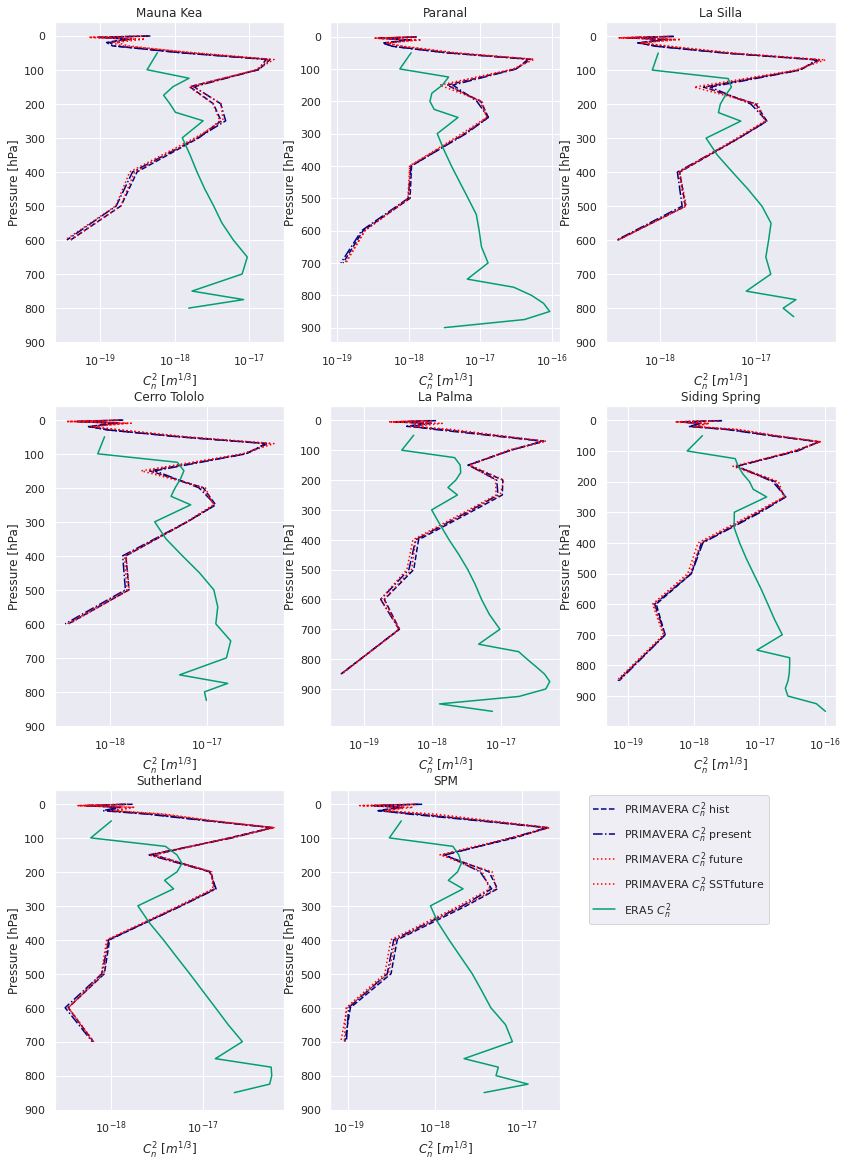

In [6]:

# loop through sites
# create a big plot (all 8 sites on one pdf page)
fig = plt.figure(figsize = (14, 20)) #,constrained_layout=True) # (this is not compatible with tight_layout)

gs = fig.add_gridspec(3, 3)

# ax1 = fig.add_subplot(gs[0, 0]) # diurnal cycle
# ax0 = fig.add_subplot(gs[0, 1]) # seasonal cycle
# ax3 = fig.add_subplot(gs[1, 0]) # span timeseries over two subplot lengths
# ax4 = fig.add_subplot(gs[1, 1]) # taylor diagram
# ax5 = fig.add_subplot(gs[2, 0]) # span timeseries over two subplot lengths
# ax6 = fig.add_subplot(gs[2, 1]) # taylor diagram
# ax7 = fig.add_subplot(gs[3, 0]) # span timeseries over two subplot lengths
# ax8 = fig.add_subplot(gs[3, 1]) # taylor diagram

for idx in range(0, 8):
    # or define index for one iteration only
    # idx = 0

    # define axis on which to plot
    ax = fig.add_subplot(gs[int((idx - (idx%3))/3), idx%3]) # int((i idx - (idx%2))/2), idx%2

    print(d_site_lonlat_data['site_name'][idx])
    # lon_obs and lat_obs are in 0-360 format!!
    lon = d_site_lonlat_data['lon_obs'][idx]
    lat = d_site_lonlat_data['lat_obs'][idx]

    ls_pr_levels_clim_model = d_site_lonlat_data['ls_pr_levels_clim_model'][idx]
    site_name_folder = d_site_lonlat_data['site_name_folder'][idx]

    list_of_single_level_model_clim_params = ['Cn2']

    d_model = {"HadGEM": {"folders": ['hist','present', 'future', 'SSTfuture'],"taylor_folder": ['hist','present'], "single_lev_var": list_of_single_level_model_clim_params,  "name": "HadGEM3-GC31-HM"},
                    "EC-Earth": {"folders": ['hist', 'future'],"taylor_folder": ['hist'],"single_lev_var": list_of_single_level_model_clim_params, "name": "EC-Earth3P-HR"} ,
                    "CNRM": {"folders": ['hist','present', 'future', 'SSTfuture'], "taylor_folder": ['hist','present'], "single_lev_var": list_of_single_level_model_clim_params, "name": "CNRM-CM6-1-HR"},
                    "MPI": {"folders": ['hist', 'present'],"taylor_folder": ['hist','present'],"single_lev_var": list_of_single_level_model_clim_params, "name": "MPI-ESM1-2-XR"},
                    "CMCC": {"folders": ['hist','present', 'future', 'SSTfuture'],"taylor_folder": ['hist','present'],"single_lev_var": list_of_single_level_model_clim_params, "name": "CMCC-CM2-VHR4"},
                    "ECMWF": {"folders": ['hist', 'present'],"taylor_folder": ['hist','present'],"single_lev_var": list_of_single_level_model_clim_params, "name": "ECMWF-IFS-HR"} }
        
    # calculate d_Ensemble (there is no d_Ensemble of Cn2 stored somewhere up to now)
    d_Ensemble = {"folders": ['hist','present', 'future', 'SSTfuture'], "single_lev_var": list_of_single_level_model_clim_params}
    
    for clim_key in d_model.keys():

        # read in ds_Cn2 for every model
        d_model[clim_key]['ds_Cn2'] = climxa.get_PRIMAVERA(d_model, clim_key, site_name_folder, single_level=True)

    # calculate ensemble mean of time medians
    for forcing in d_Ensemble['folders']:

        ls_Cn2_primavera = []

        for clim_key in d_model.keys():
            
            # # plot vertical profile (median)
            # plt.plot(d_model[clim_key]['ds_Cn2']["Cn2 " + forcing].median(dim='time'), d_model[clim_key]['ds_Cn2'].level)
            
            # calculate ensemble for every forcing, take time median
            if forcing in d_model[clim_key]['folders']:
                ls_Cn2_primavera.append(d_model[clim_key]['ds_Cn2']["Cn2 " + forcing].median(dim='time'))

        # compose d_Ensemble dataset
        d_Ensemble['Cn2 ' + forcing] = np.mean(ls_Cn2_primavera, axis=0)

    # plotting
    pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000
    lin_st = ['dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1, 1, 1))]
    line_list = []

    for forcing in d_Ensemble['folders']:

        # choose the right linestyle
        if forcing=='hist':
            forced_linestyle = lin_st[0]
            color = 'navy'
        elif forcing=='present':
            forced_linestyle = lin_st[1]
            color = 'navy'
        elif forcing=='future':
            forced_linestyle = lin_st[2]
            color = 'red'
        
        ax.plot(d_Ensemble['Cn2 ' + forcing], pr_levels_list[0:(len(d_Ensemble['Cn2 ' + forcing]))], 
                        linestyle=forced_linestyle, color=color)

        # for legend
        line_list.append(Line2D([0], [0], linestyle = forced_linestyle, color = color, label = r'PRIMAVERA $C_n^2$ ' + forcing))


    #### ERA5
    # load data
    path_Cn2 = './sites/'+ site_name_folder + '/Data/Era_5/Cn2/ds_ERA5_Cn2_profile_hourly_nearest.nc'
    ds_ERA5_Cn2 = xr.open_dataset(path_Cn2)

    # plot Cn2 profile
    ax.plot(ds_ERA5_Cn2['Cn2'].median(dim='time'), ds_ERA5_Cn2.level, linestyle = '-', color = '#009e73') # goes until 50hPa (glad I included it until 50hPa!)

    # for legend
    line_list.append(Line2D([0], [0], linestyle = '-', color = '#009e73', label = r'ERA5 $C_n^2$'))


    # maybe I have to cut off the integration of PRIMAVERA to get rid of the peak at 70hPa to increase correlation of osborn seeing?

    # change site label
    if site_name_folder == 'MaunaKea':
        site_noUnderline = 'Mauna Kea'
    elif site_name_folder == 'siding_spring':
        site_noUnderline = 'Siding Spring'
    else:
        site_noUnderline = site_name_folder.replace('_', ' ')

    ax.set_xscale('log')
    ax.set_yticks(np.arange(0, 1000, 100))
    plt.gca().invert_yaxis()
    ax.set_xlabel(r'$C_n^2$ $[m^{1/3}]$')
    ax.set_ylabel('Pressure [hPa]')
    ax.set_title(site_noUnderline)

    if idx == 7:
        # plot legend into empty spot
        # ax_legend = fig.add_subplot(gs[2,2]) # int((i idx - (idx%2))/2), idx%2
        ax.legend(handles=line_list, loc='upper left', bbox_to_anchor= (1.1, 1))

# save fig
# fig.savefig('./Model_evaluation/seeing_nc/All_Sites_Cn2_vertical_profile.pdf', bbox_inches = 'tight', pad_inches=0.0)
# fig.savefig('./publication/figures/All_Sites_Cn2_vertical_profile.pdf', bbox_inches = 'tight', pad_inches=0.0)

plt.show()


In [7]:
ds_ERA5_Cn2['Cn2']

<xarray.DataArray 'Cn2' (level: 22, time: 361798)>
array([[2.391715e-19, 3.552252e-19, 4.268375e-19, ...,          nan,
                 nan,          nan],
       [1.053602e-18, 8.945198e-19, 6.425568e-19, ...,          nan,
                 nan,          nan],
       [1.918703e-18, 1.222825e-18, 2.523492e-18, ...,          nan,
                 nan,          nan],
       ...,
       [1.991590e-19, 9.787881e-19, 9.210610e-18, ...,          nan,
                 nan,          nan],
       [2.952922e-18, 5.454980e-18, 2.670005e-18, ...,          nan,
                 nan,          nan],
       [5.582440e-18, 5.604173e-18, 2.445525e-18, ...,          nan,
                 nan,          nan]])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2020-04-09T21:00:00
  * level    (level) int64 50 100 125 150 175 200 ... 700 750 775 800 825 850
Attributes:
    long_name:  Cn2
    units:      m^(1/3)

Mauna Kea (USA)
Cerro Paranal (Chile)
La Silla (Chile)
Cerro Tololo (Chile)
La Palma (Spain)
Siding Spring (Australia)
Sutherland (South Africa)
San Pedro Martir (Mexico)


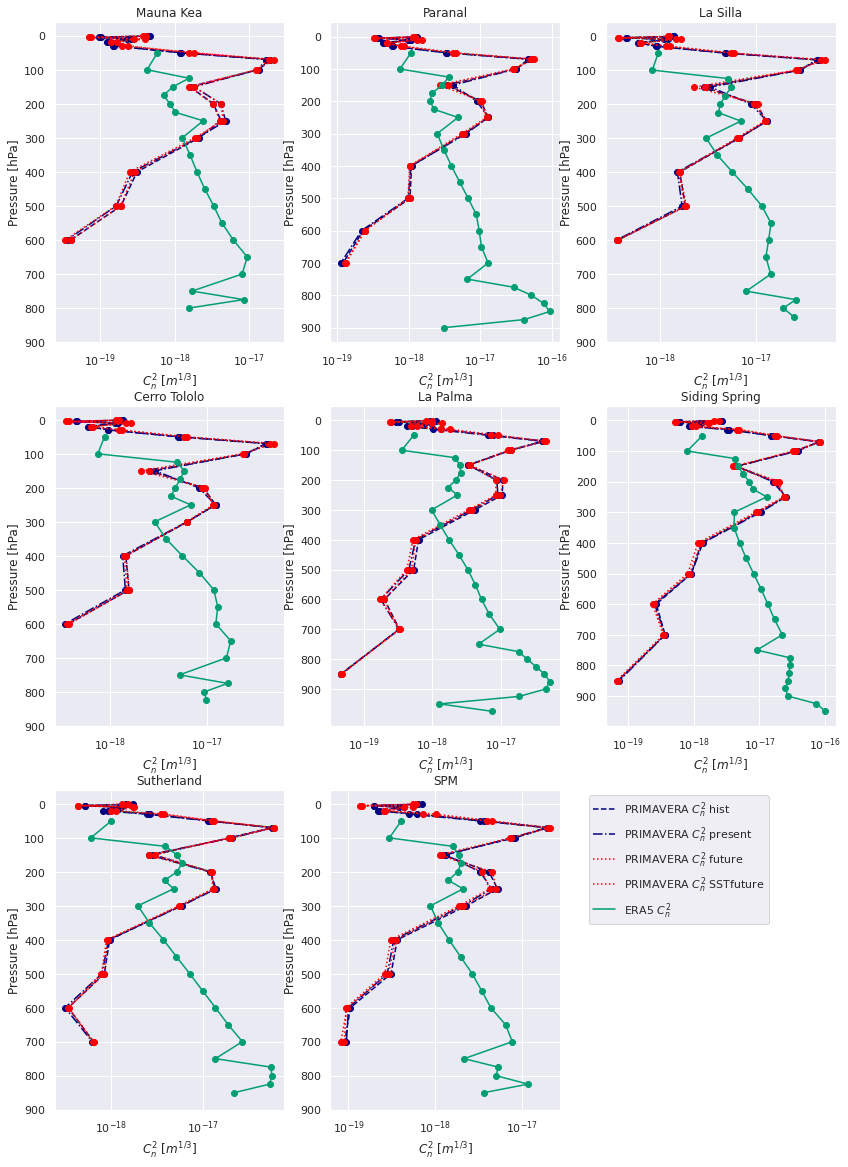

In [8]:

# loop through sites
# create a big plot (all 8 sites on one pdf page)
fig = plt.figure(figsize = (14, 20)) #,constrained_layout=True) # (this is not compatible with tight_layout)

gs = fig.add_gridspec(3, 3)

# ax1 = fig.add_subplot(gs[0, 0]) # diurnal cycle
# ax0 = fig.add_subplot(gs[0, 1]) # seasonal cycle
# ax3 = fig.add_subplot(gs[1, 0]) # span timeseries over two subplot lengths
# ax4 = fig.add_subplot(gs[1, 1]) # taylor diagram
# ax5 = fig.add_subplot(gs[2, 0]) # span timeseries over two subplot lengths
# ax6 = fig.add_subplot(gs[2, 1]) # taylor diagram
# ax7 = fig.add_subplot(gs[3, 0]) # span timeseries over two subplot lengths
# ax8 = fig.add_subplot(gs[3, 1]) # taylor diagram

for idx in range(0, 8):
    # or define index for one iteration only
    # idx = 0

    # define axis on which to plot
    ax = fig.add_subplot(gs[int((idx - (idx%3))/3), idx%3]) # int((i idx - (idx%2))/2), idx%2

    print(d_site_lonlat_data['site_name'][idx])
    # lon_obs and lat_obs are in 0-360 format!!
    lon = d_site_lonlat_data['lon_obs'][idx]
    lat = d_site_lonlat_data['lat_obs'][idx]

    ls_pr_levels_clim_model = d_site_lonlat_data['ls_pr_levels_clim_model'][idx]
    site_name_folder = d_site_lonlat_data['site_name_folder'][idx]

    list_of_single_level_model_clim_params = ['Cn2']

    d_model = {"HadGEM": {"folders": ['hist','present', 'future', 'SSTfuture'],"taylor_folder": ['hist','present'], "single_lev_var": list_of_single_level_model_clim_params,  "name": "HadGEM3-GC31-HM"},
                    "EC-Earth": {"folders": ['hist', 'future'],"taylor_folder": ['hist'],"single_lev_var": list_of_single_level_model_clim_params, "name": "EC-Earth3P-HR"} ,
                    "CNRM": {"folders": ['hist','present', 'future', 'SSTfuture'], "taylor_folder": ['hist','present'], "single_lev_var": list_of_single_level_model_clim_params, "name": "CNRM-CM6-1-HR"},
                    "MPI": {"folders": ['hist', 'present'],"taylor_folder": ['hist','present'],"single_lev_var": list_of_single_level_model_clim_params, "name": "MPI-ESM1-2-XR"},
                    "CMCC": {"folders": ['hist','present', 'future', 'SSTfuture'],"taylor_folder": ['hist','present'],"single_lev_var": list_of_single_level_model_clim_params, "name": "CMCC-CM2-VHR4"},
                    "ECMWF": {"folders": ['hist', 'present'],"taylor_folder": ['hist','present'],"single_lev_var": list_of_single_level_model_clim_params, "name": "ECMWF-IFS-HR"} }
        
    # calculate d_Ensemble (there is no d_Ensemble of Cn2 stored somewhere up to now)
    d_Ensemble = {"folders": ['hist','present', 'future', 'SSTfuture'], "single_lev_var": list_of_single_level_model_clim_params}
    
    for clim_key in d_model.keys():

        # read in ds_Cn2 for every model
        d_model[clim_key]['ds_Cn2'] = climxa.get_PRIMAVERA(d_model, clim_key, site_name_folder, single_level=True)

    # calculate ensemble mean of time medians
    for forcing in d_Ensemble['folders']:

        ls_Cn2_primavera = []

        for clim_key in d_model.keys():
            
            # # plot vertical profile (median)
            # plt.plot(d_model[clim_key]['ds_Cn2']["Cn2 " + forcing].median(dim='time'), d_model[clim_key]['ds_Cn2'].level)
            
            # calculate ensemble for every forcing, take time median
            if forcing in d_model[clim_key]['folders']:
                ls_Cn2_primavera.append(d_model[clim_key]['ds_Cn2']["Cn2 " + forcing].median(dim='time'))

        # compose d_Ensemble dataset
        d_Ensemble['Cn2 ' + forcing] = np.mean(ls_Cn2_primavera, axis=0)

    # plotting
    pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000
    lin_st = ['dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1, 1, 1))]
    line_list = []

    for forcing in d_Ensemble['folders']:

        # choose the right linestyle
        if forcing=='hist':
            forced_linestyle = lin_st[0]
            color = 'navy'
        elif forcing=='present':
            forced_linestyle = lin_st[1]
            color = 'navy'
        elif forcing=='future':
            forced_linestyle = lin_st[2]
            color = 'red'
        
        ax.plot(d_Ensemble['Cn2 ' + forcing], pr_levels_list[0:(len(d_Ensemble['Cn2 ' + forcing]))], 
                        linestyle=forced_linestyle, color=color, marker='o')

        # for legend
        line_list.append(Line2D([0], [0], linestyle = forced_linestyle, color = color, label = r'PRIMAVERA $C_n^2$ ' + forcing))


    #### ERA5
    # load data
    path_Cn2 = './sites/'+ site_name_folder + '/Data/Era_5/Cn2/ds_ERA5_Cn2_profile_hourly_nearest.nc'
    ds_ERA5_Cn2 = xr.open_dataset(path_Cn2)

    # plot Cn2 profile
    ax.plot(ds_ERA5_Cn2['Cn2'].median(dim='time'), ds_ERA5_Cn2.level, linestyle = '-', color = '#009e73', marker='o') # goes until 50hPa (glad I included it until 50hPa!)

    # for legend
    line_list.append(Line2D([0], [0], linestyle = '-', color = '#009e73', label = r'ERA5 $C_n^2$'))


    # maybe I have to cut off the integration of PRIMAVERA to get rid of the peak at 70hPa to increase correlation of osborn seeing?

    # change site label
    if site_name_folder == 'MaunaKea':
        site_noUnderline = 'Mauna Kea'
    elif site_name_folder == 'siding_spring':
        site_noUnderline = 'Siding Spring'
    else:
        site_noUnderline = site_name_folder.replace('_', ' ')

    ax.set_xscale('log')
    ax.set_yticks(np.arange(0, 1000, 100))
    plt.gca().invert_yaxis()
    ax.set_xlabel(r'$C_n^2$ $[m^{1/3}]$')
    ax.set_ylabel('Pressure [hPa]')
    ax.set_title(site_noUnderline)

    if idx == 7:
        # plot legend into empty spot
        # ax_legend = fig.add_subplot(gs[2,2]) # int((i idx - (idx%2))/2), idx%2
        ax.legend(handles=line_list, loc='upper left', bbox_to_anchor= (1.1, 1))

# save fig
# fig.savefig('./Model_evaluation/seeing_nc/All_Sites_Cn2_vertical_profile.pdf', bbox_inches = 'tight', pad_inches=0.0)
# fig.savefig('./publication/figures/All_Sites_Cn2_vertical_profile.pdf', bbox_inches = 'tight', pad_inches=0.0)

plt.show()


Mauna Kea (USA)


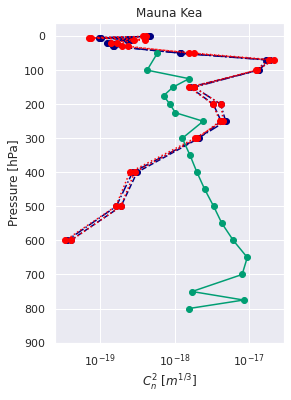

In [9]:

# loop through sites
# create a big plot (all 8 sites on one pdf page)
fig = plt.figure(figsize = (14, 20)) #,constrained_layout=True) # (this is not compatible with tight_layout)

gs = fig.add_gridspec(3, 3)

# ax1 = fig.add_subplot(gs[0, 0]) # diurnal cycle
# ax0 = fig.add_subplot(gs[0, 1]) # seasonal cycle
# ax3 = fig.add_subplot(gs[1, 0]) # span timeseries over two subplot lengths
# ax4 = fig.add_subplot(gs[1, 1]) # taylor diagram
# ax5 = fig.add_subplot(gs[2, 0]) # span timeseries over two subplot lengths
# ax6 = fig.add_subplot(gs[2, 1]) # taylor diagram
# ax7 = fig.add_subplot(gs[3, 0]) # span timeseries over two subplot lengths
# ax8 = fig.add_subplot(gs[3, 1]) # taylor diagram

for idx in range(0, 1):
    # or define index for one iteration only
    # idx = 0

    # define axis on which to plot
    ax = fig.add_subplot(gs[int((idx - (idx%3))/3), idx%3]) # int((i idx - (idx%2))/2), idx%2

    print(d_site_lonlat_data['site_name'][idx])
    # lon_obs and lat_obs are in 0-360 format!!
    lon = d_site_lonlat_data['lon_obs'][idx]
    lat = d_site_lonlat_data['lat_obs'][idx]

    ls_pr_levels_clim_model = d_site_lonlat_data['ls_pr_levels_clim_model'][idx]
    site_name_folder = d_site_lonlat_data['site_name_folder'][idx]

    list_of_single_level_model_clim_params = ['Cn2']

    d_model = {"HadGEM": {"folders": ['hist','present', 'future', 'SSTfuture'],"taylor_folder": ['hist','present'], "single_lev_var": list_of_single_level_model_clim_params,  "name": "HadGEM3-GC31-HM"},
                    "EC-Earth": {"folders": ['hist', 'future'],"taylor_folder": ['hist'],"single_lev_var": list_of_single_level_model_clim_params, "name": "EC-Earth3P-HR"} ,
                    "CNRM": {"folders": ['hist','present', 'future', 'SSTfuture'], "taylor_folder": ['hist','present'], "single_lev_var": list_of_single_level_model_clim_params, "name": "CNRM-CM6-1-HR"},
                    "MPI": {"folders": ['hist', 'present'],"taylor_folder": ['hist','present'],"single_lev_var": list_of_single_level_model_clim_params, "name": "MPI-ESM1-2-XR"},
                    "CMCC": {"folders": ['hist','present', 'future', 'SSTfuture'],"taylor_folder": ['hist','present'],"single_lev_var": list_of_single_level_model_clim_params, "name": "CMCC-CM2-VHR4"},
                    "ECMWF": {"folders": ['hist', 'present'],"taylor_folder": ['hist','present'],"single_lev_var": list_of_single_level_model_clim_params, "name": "ECMWF-IFS-HR"} }
        
    # calculate d_Ensemble (there is no d_Ensemble of Cn2 stored somewhere up to now)
    d_Ensemble = {"folders": ['hist','present', 'future', 'SSTfuture'], "single_lev_var": list_of_single_level_model_clim_params}
    
    for clim_key in d_model.keys():

        # read in ds_Cn2 for every model
        d_model[clim_key]['ds_Cn2'] = climxa.get_PRIMAVERA(d_model, clim_key, site_name_folder, single_level=True)

    # calculate ensemble mean of time medians
    for forcing in d_Ensemble['folders']:

        ls_Cn2_primavera = []

        for clim_key in d_model.keys():
            
            # # plot vertical profile (median)
            # plt.plot(d_model[clim_key]['ds_Cn2']["Cn2 " + forcing].median(dim='time'), d_model[clim_key]['ds_Cn2'].level)
            
            # calculate ensemble for every forcing, take time median
            if forcing in d_model[clim_key]['folders']:
                ls_Cn2_primavera.append(d_model[clim_key]['ds_Cn2']["Cn2 " + forcing].median(dim='time'))

        # compose d_Ensemble dataset
        d_Ensemble['Cn2 ' + forcing] = np.mean(ls_Cn2_primavera, axis=0)

    # plotting
    pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000
    lin_st = ['dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1, 1, 1))]
    line_list = []

    for forcing in d_Ensemble['folders']:

        # choose the right linestyle
        if forcing=='hist':
            forced_linestyle = lin_st[0]
            color = 'navy'
        elif forcing=='present':
            forced_linestyle = lin_st[1]
            color = 'navy'
        elif forcing=='future':
            forced_linestyle = lin_st[2]
            color = 'red'
        
        ax.plot(d_Ensemble['Cn2 ' + forcing], pr_levels_list[0:(len(d_Ensemble['Cn2 ' + forcing]))], 
                        linestyle=forced_linestyle, color=color, marker='o')

        # for legend
        line_list.append(Line2D([0], [0], linestyle = forced_linestyle, color = color, label = r'PRIMAVERA $C_n^2$ ' + forcing))


    #### ERA5
    # load data
    path_Cn2 = './sites/'+ site_name_folder + '/Data/Era_5/Cn2/ds_ERA5_Cn2_profile_hourly_nearest.nc'
    ds_ERA5_Cn2 = xr.open_dataset(path_Cn2)

    # plot Cn2 profile
    ax.plot(ds_ERA5_Cn2['Cn2'].median(dim='time'), ds_ERA5_Cn2.level, linestyle = '-', color = '#009e73', marker='o') # goes until 50hPa (glad I included it until 50hPa!)

    # for legend
    line_list.append(Line2D([0], [0], linestyle = '-', color = '#009e73', label = r'ERA5 $C_n^2$'))

    ax.set_xticks(ds_ERA5_Cn2.level)

    # maybe I have to cut off the integration of PRIMAVERA to get rid of the peak at 70hPa to increase correlation of osborn seeing?

    # change site label
    if site_name_folder == 'MaunaKea':
        site_noUnderline = 'Mauna Kea'
    elif site_name_folder == 'siding_spring':
        site_noUnderline = 'Siding Spring'
    else:
        site_noUnderline = site_name_folder.replace('_', ' ')

    ax.set_xscale('log')
    ax.set_yticks(np.arange(0, 1000, 100))
    plt.gca().invert_yaxis()
    ax.set_xlabel(r'$C_n^2$ $[m^{1/3}]$')
    ax.set_ylabel('Pressure [hPa]')
    ax.set_title(site_noUnderline)

    if idx == 7:
        # plot legend into empty spot
        # ax_legend = fig.add_subplot(gs[2,2]) # int((i idx - (idx%2))/2), idx%2
        ax.legend(handles=line_list, loc='upper left', bbox_to_anchor= (1.1, 1))

# save fig
# fig.savefig('./Model_evaluation/seeing_nc/All_Sites_Cn2_vertical_profile.pdf', bbox_inches = 'tight', pad_inches=0.0)
# fig.savefig('./publication/figures/All_Sites_Cn2_vertical_profile.pdf', bbox_inches = 'tight', pad_inches=0.0)

plt.show()


In [10]:
ax.set_xticks(ds_ERA5_Cn2.level)


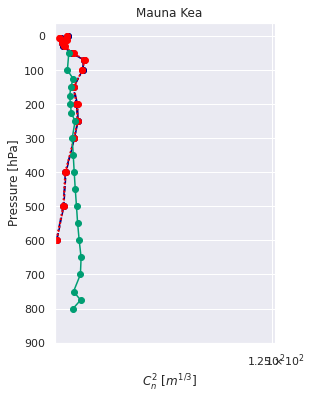

In [11]:
fig

Mauna Kea (USA)


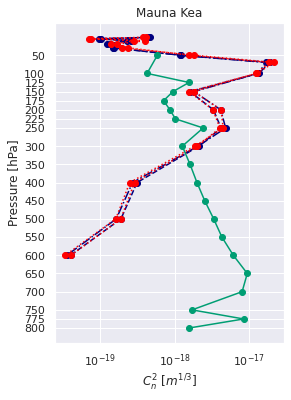

In [12]:

# loop through sites
# create a big plot (all 8 sites on one pdf page)
fig = plt.figure(figsize = (14, 20)) #,constrained_layout=True) # (this is not compatible with tight_layout)

gs = fig.add_gridspec(3, 3)

# ax1 = fig.add_subplot(gs[0, 0]) # diurnal cycle
# ax0 = fig.add_subplot(gs[0, 1]) # seasonal cycle
# ax3 = fig.add_subplot(gs[1, 0]) # span timeseries over two subplot lengths
# ax4 = fig.add_subplot(gs[1, 1]) # taylor diagram
# ax5 = fig.add_subplot(gs[2, 0]) # span timeseries over two subplot lengths
# ax6 = fig.add_subplot(gs[2, 1]) # taylor diagram
# ax7 = fig.add_subplot(gs[3, 0]) # span timeseries over two subplot lengths
# ax8 = fig.add_subplot(gs[3, 1]) # taylor diagram

for idx in range(0, 1):
    # or define index for one iteration only
    # idx = 0

    # define axis on which to plot
    ax = fig.add_subplot(gs[int((idx - (idx%3))/3), idx%3]) # int((i idx - (idx%2))/2), idx%2

    print(d_site_lonlat_data['site_name'][idx])
    # lon_obs and lat_obs are in 0-360 format!!
    lon = d_site_lonlat_data['lon_obs'][idx]
    lat = d_site_lonlat_data['lat_obs'][idx]

    ls_pr_levels_clim_model = d_site_lonlat_data['ls_pr_levels_clim_model'][idx]
    site_name_folder = d_site_lonlat_data['site_name_folder'][idx]

    list_of_single_level_model_clim_params = ['Cn2']

    d_model = {"HadGEM": {"folders": ['hist','present', 'future', 'SSTfuture'],"taylor_folder": ['hist','present'], "single_lev_var": list_of_single_level_model_clim_params,  "name": "HadGEM3-GC31-HM"},
                    "EC-Earth": {"folders": ['hist', 'future'],"taylor_folder": ['hist'],"single_lev_var": list_of_single_level_model_clim_params, "name": "EC-Earth3P-HR"} ,
                    "CNRM": {"folders": ['hist','present', 'future', 'SSTfuture'], "taylor_folder": ['hist','present'], "single_lev_var": list_of_single_level_model_clim_params, "name": "CNRM-CM6-1-HR"},
                    "MPI": {"folders": ['hist', 'present'],"taylor_folder": ['hist','present'],"single_lev_var": list_of_single_level_model_clim_params, "name": "MPI-ESM1-2-XR"},
                    "CMCC": {"folders": ['hist','present', 'future', 'SSTfuture'],"taylor_folder": ['hist','present'],"single_lev_var": list_of_single_level_model_clim_params, "name": "CMCC-CM2-VHR4"},
                    "ECMWF": {"folders": ['hist', 'present'],"taylor_folder": ['hist','present'],"single_lev_var": list_of_single_level_model_clim_params, "name": "ECMWF-IFS-HR"} }
        
    # calculate d_Ensemble (there is no d_Ensemble of Cn2 stored somewhere up to now)
    d_Ensemble = {"folders": ['hist','present', 'future', 'SSTfuture'], "single_lev_var": list_of_single_level_model_clim_params}
    
    for clim_key in d_model.keys():

        # read in ds_Cn2 for every model
        d_model[clim_key]['ds_Cn2'] = climxa.get_PRIMAVERA(d_model, clim_key, site_name_folder, single_level=True)

    # calculate ensemble mean of time medians
    for forcing in d_Ensemble['folders']:

        ls_Cn2_primavera = []

        for clim_key in d_model.keys():
            
            # # plot vertical profile (median)
            # plt.plot(d_model[clim_key]['ds_Cn2']["Cn2 " + forcing].median(dim='time'), d_model[clim_key]['ds_Cn2'].level)
            
            # calculate ensemble for every forcing, take time median
            if forcing in d_model[clim_key]['folders']:
                ls_Cn2_primavera.append(d_model[clim_key]['ds_Cn2']["Cn2 " + forcing].median(dim='time'))

        # compose d_Ensemble dataset
        d_Ensemble['Cn2 ' + forcing] = np.mean(ls_Cn2_primavera, axis=0)

    # plotting
    pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000
    lin_st = ['dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1, 1, 1))]
    line_list = []

    for forcing in d_Ensemble['folders']:

        # choose the right linestyle
        if forcing=='hist':
            forced_linestyle = lin_st[0]
            color = 'navy'
        elif forcing=='present':
            forced_linestyle = lin_st[1]
            color = 'navy'
        elif forcing=='future':
            forced_linestyle = lin_st[2]
            color = 'red'
        
        ax.plot(d_Ensemble['Cn2 ' + forcing], pr_levels_list[0:(len(d_Ensemble['Cn2 ' + forcing]))], 
                        linestyle=forced_linestyle, color=color, marker='o')

        # for legend
        line_list.append(Line2D([0], [0], linestyle = forced_linestyle, color = color, label = r'PRIMAVERA $C_n^2$ ' + forcing))


    #### ERA5
    # load data
    path_Cn2 = './sites/'+ site_name_folder + '/Data/Era_5/Cn2/ds_ERA5_Cn2_profile_hourly_nearest.nc'
    ds_ERA5_Cn2 = xr.open_dataset(path_Cn2)

    # plot Cn2 profile
    ax.plot(ds_ERA5_Cn2['Cn2'].median(dim='time'), ds_ERA5_Cn2.level, linestyle = '-', color = '#009e73', marker='o') # goes until 50hPa (glad I included it until 50hPa!)

    # for legend
    line_list.append(Line2D([0], [0], linestyle = '-', color = '#009e73', label = r'ERA5 $C_n^2$'))

    

    # maybe I have to cut off the integration of PRIMAVERA to get rid of the peak at 70hPa to increase correlation of osborn seeing?

    # change site label
    if site_name_folder == 'MaunaKea':
        site_noUnderline = 'Mauna Kea'
    elif site_name_folder == 'siding_spring':
        site_noUnderline = 'Siding Spring'
    else:
        site_noUnderline = site_name_folder.replace('_', ' ')

    ax.set_xscale('log')
    # ax.set_yticks(np.arange(0, 1000, 100))
    ax.set_yticks(ds_ERA5_Cn2.level)
    plt.gca().invert_yaxis()
    ax.set_xlabel(r'$C_n^2$ $[m^{1/3}]$')
    ax.set_ylabel('Pressure [hPa]')
    ax.set_title(site_noUnderline)

    if idx == 7:
        # plot legend into empty spot
        # ax_legend = fig.add_subplot(gs[2,2]) # int((i idx - (idx%2))/2), idx%2
        ax.legend(handles=line_list, loc='upper left', bbox_to_anchor= (1.1, 1))

# save fig
# fig.savefig('./Model_evaluation/seeing_nc/All_Sites_Cn2_vertical_profile.pdf', bbox_inches = 'tight', pad_inches=0.0)
# fig.savefig('./publication/figures/All_Sites_Cn2_vertical_profile.pdf', bbox_inches = 'tight', pad_inches=0.0)

plt.show()


In [13]:
ds_ERA5_Cn2['Cn2']


<xarray.DataArray 'Cn2' (level: 20, time: 361798)>
array([[7.152914e-19, 6.752434e-19, 6.333948e-19, ...,          nan,
                 nan,          nan],
       [9.769526e-19, 8.436098e-19, 6.505296e-19, ...,          nan,
                 nan,          nan],
       [8.363829e-19, 9.525415e-19, 8.518646e-19, ...,          nan,
                 nan,          nan],
       ...,
       [5.986130e-19, 6.229420e-19, 6.936189e-19, ...,          nan,
                 nan,          nan],
       [1.792433e-18, 3.050083e-18, 2.948840e-18, ...,          nan,
                 nan,          nan],
       [7.886963e-18, 5.312050e-18, 2.315101e-18, ...,          nan,
                 nan,          nan]])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2020-04-09T21:00:00
  * level    (level) int64 50 100 125 150 175 200 ... 600 650 700 750 775 800
Attributes:
    long_name:  Cn2
    units:      m^(1/3)

In [14]:
d_Ensemble['Cn2 ' + forcing]


array([4.17575905e-19, 7.49081736e-20, 4.02836045e-19, 1.66647498e-19,
       2.40483656e-19, 1.58262413e-18, 1.88874104e-17, 1.24516802e-17,
       1.80726557e-18, 4.22896067e-18, 4.50267546e-18, 1.88130084e-18,
       2.50468143e-19, 1.62373782e-19, 3.39322092e-20])

In [15]:

# other function: plot t, u, v profile
def plot_seeing_vars_vertical_profile(idx, d_model):
    # loop through sites
    # create a big plot (all 8 sites on one pdf page)
    # fig = plt.figure(figsize = (8, 6)) # (this is not compatible with tight_layout)
    # (8, 20)
    # gs = fig.add_gridspec(1, 3)

    fig, ax = plt.subplots(1,4, figsize = (10, 6), tight_layout = True)

    # ax1 = fig.add_subplot(gs[0,0]) # t
    # ax2 = fig.add_subplot(gs[0,1]) # u
    # ax3 = fig.add_subplot(gs[0,2]) # v

    site_name_folder = d_site_lonlat_data['site_name_folder'][idx]

    lsclimvars = ['ta', 'ua', 'va', 'zg']

    for climind, clim_var in enumerate(lsclimvars):
        print(climind)
        # one ax for one clim_var
        # ax = ax[climind]

        # calculate d_Ensemble (there is no d_Ensemble of Cn2 stored somewhere up to now)
        # feed clim_var and Plev
        # d_Ensemble = {"folders": ['hist','present', 'future', 'SSTfuture'], "clim_var": clim_var}
        
        # calculate ensemble mean of time medians


            # ls_Cn2_primavera = []

        for clim_key in d_model.keys():
            for forcing in d_model[clim_key]['folders']:
                
                # plot vertical profile (median)
                ax[climind].plot(d_model[clim_key]['ds_seeing'][clim_var + " " + forcing].median(dim='time'), d_model[clim_key]['ds_seeing'].level, 
                        linestyle = 'dotted')
                
        #         # calculate ensemble for every forcing, take time median
        #         if forcing in d_model[clim_key]['folders']:
        #             ls_Cn2_primavera.append(d_model[clim_key]['ds_seeing'][clim_var + " " + forcing].median(dim='time'))

        #     # compose d_Ensemble dataset
        #     d_Ensemble[clim_var + ' ' + forcing] = np.mean(ls_Cn2_primavera, axis=0)

        # # plotting
        # pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000
        # lin_st = ['dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1, 1, 1))]
        # line_list = []

        # for forcing in d_Ensemble['folders']:

        #     # choose the right linestyle
        #     if forcing=='hist':
        #         forced_linestyle = lin_st[0]
        #         color = 'navy'
        #     elif forcing=='present':
        #         forced_linestyle = lin_st[1]
        #         color = 'navy'
        #     elif forcing=='future':
        #         forced_linestyle = lin_st[2]
        #         color = 'red'
            
        #     ax.plot(d_Ensemble['Cn2 ' + forcing], pr_levels_list[0:(len(d_Ensemble['Cn2 ' + forcing]))], 
        #                     linestyle=forced_linestyle, color=color)

        #     # for legend
        #     line_list.append(Line2D([0], [0], linestyle = forced_linestyle, color = color, label = r'PRIMAVERA $C_n^2$ ' + forcing))


        #### ERA5
        # load data
        median_path = './Astroclimate_outcome/median_nc_u_v_t/' + site_name_folder + '_median_ERA5_u_v_t_z.nc'
        ds_ERA5_median = xr.open_dataset(median_path).load()


        # plot profile
        # note: clim_var[0] only takes the first character ('u', 'v', 't')
        ax[climind].plot(ds_ERA5_median[clim_var[0]], ds_ERA5_median.level, linestyle = '-', color = '#009e73') # goes until 50hPa (glad I included it until 50hPa!)

        # for legend
        # line_list.append(Line2D([0], [0], linestyle = '-', color = '#009e73', label = r'ERA5 $C_n^2$'))

        # plot a red line at 70hPa
        ax[climind].axhline(y=70, xmin=-20, xmax=300, color = 'red')

        # maybe I have to cut off the integration of PRIMAVERA to get rid of the peak at 70hPa to increase correlation of osborn seeing?

        # change site label
        if site_name_folder == 'MaunaKea':
            site_noUnderline = 'Mauna Kea'
        elif site_name_folder == 'siding_spring':
            site_noUnderline = 'Siding Spring'
        else:
            site_noUnderline = site_name_folder.replace('_', ' ')

        # ax.set_xscale('log')
        # ax.set_yticks(np.arange(0, 1000, 100))
        ax[climind].invert_yaxis()
        ax[climind].set_xlabel(clim_var)
        ax[climind].set_ylabel('Pressure [hPa]')
        # ax.set_title(site_noUnderline)



        # if idx == 7:
        #     # plot legend into empty spot
        #     # ax_legend = fig.add_subplot(gs[2,2]) # int((i idx - (idx%2))/2), idx%2
        #     ax.legend(handles=line_list, loc='upper left', bbox_to_anchor= (1.1, 1))

    # save fig
    # fig.savefig('./Model_evaluation/seeing_nc/All_Sites_Cn2_vertical_profile.pdf', bbox_inches = 'tight', pad_inches=0.0)
    # fig.savefig('./publication/figures/All_Sites_Cn2_vertical_profile.pdf', bbox_inches = 'tight', pad_inches=0.0)

    # plt.show()

    return fig


In [16]:
# loop through sites

for idx in range(0,8):

    site_name_folder = d_site_lonlat_data['site_name_folder'][idx]

    d_model = get_PRIMAVERA_seeing_vars(idx)

    fig = plot_seeing_vars_vertical_profile(idx, d_model)

    # save fig
    fig.savefig('./Model_evaluation/seeing_nc/vertical_profile_u_v_t/'+ site_name_folder + '_vertical_profile_u_v_t.png', bbox_inches = 'tight', pad_inches=0.0, dpi=400)

# remember: ua: eastward wind (going to the east (jet stream!)), va: northward wind

# plot Cn2 (possible?)
# calc cn2 out of medians

...


NameError: name 'get_PRIMAVERA_seeing_vars' is not defined

In [17]:
# read in seeing vars (t, u, v)
# only ERA5!
def get_seeing_variables(idx, d_site_lonlat_data):

    lon = d_site_lonlat_data['lon_obs'][idx]
    lat = d_site_lonlat_data['lat_obs'][idx]
    site_name_folder = d_site_lonlat_data['site_name_folder'][idx]

    chile_grid = ['Tololo', 'Pachon', 'Silla']
    if any(x in site_name_folder for x in chile_grid):
        site_ERA = 'Paranal'
    else:
        site_ERA = site_name_folder

    if lon > 180:
        my_ERA5_lon = lon - 360 # e.g. 360-17.88 = 342.12 > 180 --> lon = 342.12 - 360 = -17.88
        print('I adapted lon to -180/180 lon. new lon is: {}'.format(my_ERA5_lon))
    else:
        my_ERA5_lon = lon

    # use function which loads in all specific humidity datasets 
    # and integrates them to specific humidity

    if site_ERA == 'Paranal': # Paranal
        seeing_data_path =  './sites/' + site_ERA + '/Era5_data/seeing/'
    else:
        seeing_data_path =  './sites/' + site_ERA + '/Data/Era_5/seeing/'

    ds_seeing_vars = climxa.read_ERA5_seeing_data(seeing_data_path, my_ERA5_lon, lat)
    ds_seeing_vars = ds_seeing_vars.load() # load here to prevent program from running 

    return ds_seeing_vars

# PRIMAVERA
def get_PRIMAVERA_seeing_vars(idx):
    
    # or define index for one iteration only
    # idx = 0

    print(d_site_lonlat_data['site_name'][idx])
    # lon_obs and lat_obs are in 0-360 format!!
    lon = d_site_lonlat_data['lon_obs'][idx]
    lat = d_site_lonlat_data['lat_obs'][idx]

    ls_pr_levels_clim_model = d_site_lonlat_data['ls_pr_levels_clim_model'][idx]
    site_name_folder = d_site_lonlat_data['site_name_folder'][idx]

    # for calibration of the wind speed seeing and the osborn seeing, read in in situ data
    list_of_insitu_vars = ['Seeing ' + site_name_folder]

    # pressure level of seeing integration
    path_seeing = d_site_lonlat_data['path_ds_seeing'][idx] 

    # special case of siding_spring, where we have only yearly data:
    if idx == 5:
        df_siding_spring = pd.read_csv(path_seeing, index_col='year', delimiter='\t')
        ds_siding_spring = df_siding_spring.to_xarray()
        mean_insitu = np.mean(ds_siding_spring['ds_mean_year'])


    elif idx == 6: # sutherland: no insitu data

        mean_insitu = 1.32 # from Optical turbulence characterization at the SAAO Sutherland site (L. Catala)

    else:
        # read in ds_hourly (in-situ data)
        # ds_hourly = climxa.df_to_xarray('./sites/Paranal/Data/    # attention! taylor folders can change! think about that in the return...in-situ/hourly_meteo/hourly_Paranal_FA_Seeing_instantaneous_MASS_DIMM_free_atmosphere_1804.csv') # hourly_Paranal_Seeing.csv'), ['Seeing Paranal']
        ds_hourly = climxa.df_to_xarray(path_seeing)
    
        mean_insitu = np.mean(ds_hourly[list_of_insitu_vars[0]])

    d_model = {"HadGEM": {"folders": ['hist','present', 'future', 'SSTfuture'],'Plev': ls_pr_levels_clim_model, "name": "HadGEM3-GC31-HM"},
                    "EC-Earth": {"folders": ['hist', 'future'], 'Plev': ls_pr_levels_clim_model, "name": "EC-Earth3P-HR"} ,
                    "CNRM": {"folders": ['hist','present', 'future', 'SSTfuture'],  'Plev': ls_pr_levels_clim_model, "name": "CNRM-CM6-1-HR"},
                    "MPI": {"folders": ['hist', 'present'], 'Plev': ls_pr_levels_clim_model, "name": "MPI-ESM1-2-XR"},
                    "CMCC": {"folders": ['hist','present', 'future', 'SSTfuture'], 'Plev': ls_pr_levels_clim_model, "name": "CMCC-CM2-VHR4"},
                    "ECMWF": {"folders": ['hist', 'present'], 'Plev': ls_pr_levels_clim_model, "name": "ECMWF-IFS-HR"} }

    for clim_key in d_model.keys():
        start_time = time.time() # measure elapsed time

        print('reading data for {}, {}'.format(clim_key, site_name_folder))
        # do not forget forcing --> get_PRIMAVERA does that automatically
        ls_seeing_vars = []
        for seeing_var in ['ua', 'va', 'zg', 'ta']:
            # read model data
            d_model[clim_key]['clim_var'] = [seeing_var]
            # append dataset to list so that all seeing variables are in one dataset
            ds_temp = climxa.get_PRIMAVERA(d_model, clim_key, site_name_folder, pressure_level=True)
            
            # ds_notfind = xr.open_dataset('/home/haslebacher/chaldene/Astroclimate_Project/sites/La_Palma/Data/HighResMIP/ua/Amon/CNRM/hist_notfind.nc')
            # ds = xr.open_dataset('/home/haslebacher/chaldene/Astroclimate_Project/sites/La_Palma/Data/HighResMIP/ua/Amon/CNRM/hist.nc')
            # ds.sel(lon=lon, lat=lat, method='nearest').dropna(dim='time')

            # problem: ta and zg do not have the same lon/lat values than ua and va!!!

            # --> select lon and lat and drop lon,lat coords
            ds_temp = ds_temp.sel(longitude=lon, latitude=lat, method='nearest')
            # print(ds_temp[seeing_var + ' hist'].dropna(dim='time'))

            if seeing_var == 'ta':
                ds_temp = ds_temp + 273.15 # to Kelvin
            # drop
            ds_temp = ds_temp.reset_coords(drop=True)
            # print(ds_temp)

            ls_seeing_vars.append(ds_temp)

        # compose dataset with ua, va and zg which we need to calculate the seeing 
        # for this, nothing gets computed!!
        d_model[clim_key]['ds_seeing'] = xr.merge(ls_seeing_vars, join='outer')

    return d_model



In [18]:

# other function: plot t, u, v profile
def plot_seeing_vars_vertical_profile(idx, d_model):
    # loop through sites
    # create a big plot (all 8 sites on one pdf page)
    # fig = plt.figure(figsize = (8, 6)) # (this is not compatible with tight_layout)
    # (8, 20)
    # gs = fig.add_gridspec(1, 3)

    fig, ax = plt.subplots(1,4, figsize = (10, 6), tight_layout = True)

    # ax1 = fig.add_subplot(gs[0,0]) # t
    # ax2 = fig.add_subplot(gs[0,1]) # u
    # ax3 = fig.add_subplot(gs[0,2]) # v

    site_name_folder = d_site_lonlat_data['site_name_folder'][idx]

    lsclimvars = ['ta', 'ua', 'va', 'zg']

    for climind, clim_var in enumerate(lsclimvars):
        print(climind)
        # one ax for one clim_var
        # ax = ax[climind]

        # calculate d_Ensemble (there is no d_Ensemble of Cn2 stored somewhere up to now)
        # feed clim_var and Plev
        # d_Ensemble = {"folders": ['hist','present', 'future', 'SSTfuture'], "clim_var": clim_var}
        
        # calculate ensemble mean of time medians


            # ls_Cn2_primavera = []

        for clim_key in d_model.keys():
            for forcing in d_model[clim_key]['folders']:
                
                # plot vertical profile (median)
                ax[climind].plot(d_model[clim_key]['ds_seeing'][clim_var + " " + forcing].median(dim='time'), d_model[clim_key]['ds_seeing'].level, 
                        linestyle = 'dotted')
                
        #         # calculate ensemble for every forcing, take time median
        #         if forcing in d_model[clim_key]['folders']:
        #             ls_Cn2_primavera.append(d_model[clim_key]['ds_seeing'][clim_var + " " + forcing].median(dim='time'))

        #     # compose d_Ensemble dataset
        #     d_Ensemble[clim_var + ' ' + forcing] = np.mean(ls_Cn2_primavera, axis=0)

        # # plotting
        # pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000
        # lin_st = ['dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1, 1, 1))]
        # line_list = []

        # for forcing in d_Ensemble['folders']:

        #     # choose the right linestyle
        #     if forcing=='hist':
        #         forced_linestyle = lin_st[0]
        #         color = 'navy'
        #     elif forcing=='present':
        #         forced_linestyle = lin_st[1]
        #         color = 'navy'
        #     elif forcing=='future':
        #         forced_linestyle = lin_st[2]
        #         color = 'red'
            
        #     ax.plot(d_Ensemble['Cn2 ' + forcing], pr_levels_list[0:(len(d_Ensemble['Cn2 ' + forcing]))], 
        #                     linestyle=forced_linestyle, color=color)

        #     # for legend
        #     line_list.append(Line2D([0], [0], linestyle = forced_linestyle, color = color, label = r'PRIMAVERA $C_n^2$ ' + forcing))


        #### ERA5
        # load data
        median_path = './Astroclimate_outcome/median_nc_u_v_t/' + site_name_folder + '_median_ERA5_u_v_t_z.nc'
        ds_ERA5_median = xr.open_dataset(median_path).load()


        # plot profile
        # note: clim_var[0] only takes the first character ('u', 'v', 't')
        ax[climind].plot(ds_ERA5_median[clim_var[0]], ds_ERA5_median.level, linestyle = '-', color = '#009e73') # goes until 50hPa (glad I included it until 50hPa!)

        # for legend
        # line_list.append(Line2D([0], [0], linestyle = '-', color = '#009e73', label = r'ERA5 $C_n^2$'))

        # plot a red line at 70hPa
        ax[climind].axhline(y=70, xmin=-20, xmax=300, color = 'red')

        # maybe I have to cut off the integration of PRIMAVERA to get rid of the peak at 70hPa to increase correlation of osborn seeing?

        # change site label
        if site_name_folder == 'MaunaKea':
            site_noUnderline = 'Mauna Kea'
        elif site_name_folder == 'siding_spring':
            site_noUnderline = 'Siding Spring'
        else:
            site_noUnderline = site_name_folder.replace('_', ' ')

        # ax.set_xscale('log')
        # ax.set_yticks(np.arange(0, 1000, 100))
        ax[climind].invert_yaxis()
        ax[climind].set_xlabel(clim_var)
        ax[climind].set_ylabel('Pressure [hPa]')
        # ax.set_title(site_noUnderline)



        # if idx == 7:
        #     # plot legend into empty spot
        #     # ax_legend = fig.add_subplot(gs[2,2]) # int((i idx - (idx%2))/2), idx%2
        #     ax.legend(handles=line_list, loc='upper left', bbox_to_anchor= (1.1, 1))

    # save fig
    # fig.savefig('./Model_evaluation/seeing_nc/All_Sites_Cn2_vertical_profile.pdf', bbox_inches = 'tight', pad_inches=0.0)
    # fig.savefig('./publication/figures/All_Sites_Cn2_vertical_profile.pdf', bbox_inches = 'tight', pad_inches=0.0)

    # plt.show()

    return fig


In [20]:
ds_ERA5_median

NameError: name 'ds_ERA5_median' is not defined

In [21]:
median_path = './Astroclimate_outcome/median_nc_u_v_t/' + site_name_folder + '_median_ERA5_u_v_t_z.nc'
ds_ERA5_median = xr.open_dataset(median_path).load()


In [22]:
ds_ERA5_median


<xarray.Dataset>
Dimensions:    (level: 24)
Coordinates:
    latitude   float32 31.0
    longitude  float32 -115.5
  * level      (level) int64 50 100 125 150 175 200 ... 775 800 825 850 875 900
Data variables:
    v          (level) float32 -0.26568398 1.7164274 ... -0.14265883 -0.16809684
    u          (level) float32 -1.253613 11.955747 ... 0.34849018 0.37385225
    t          (level) float32 211.14272 204.52087 ... 291.34076 292.98694
    z          (level) float32 202204.31 161184.5 ... 12376.283 10028.156

In [23]:
ds_ERA5_median['z']

<xarray.DataArray 'z' (level: 24)>
array([202204.31 , 161184.5  , 147992.08 , 137051.67 , 127686.9  ,
       119463.14 , 112085.92 , 105356.19 ,  93347.44 ,  82802.43 ,
        73366.055,  64805.613,  56956.664,  49702.61 ,  42954.383,
        36644.656,  30720.238,  25129.781,  22446.81 ,  19832.217,
        17274.77 ,  14792.306,  12376.283,  10028.156], dtype=float32)
Coordinates:
    latitude   float32 31.0
    longitude  float32 -115.5
  * level      (level) int64 50 100 125 150 175 200 ... 775 800 825 850 875 900

In [24]:
d_model[clim_key]['ds_seeing']


<xarray.Dataset>
Dimensions:     (level: 19, time: 780)
Coordinates:
  * level       (level) int64 1000 925 850 700 600 500 400 ... 50 30 20 10 5 1
  * time        (time) datetime64[ns] 1950-01-16T12:00:00 ... 2014-12-16T12:00:00
Data variables:
    ua hist     (time, level) float32 -0.48273182 -0.44821072 ... -41.874084
    ua present  (time, level) float32 -0.33265305 -0.22975159 ... -44.091507
    va hist     (time, level) float32 -0.06882572 -0.18790531 ... -1.0305634
    va present  (time, level) float32 0.6784096 0.54558945 ... 0.9087982
    zg hist     (time, level) float32 117.01256 781.32886 ... 48140.203
    zg present  (time, level) float32 104.88585 769.7076 ... 35683.04 48082.68
    ta hist     (time, level) float32 300.3366 295.94696 ... 248.188 268.2813
    ta present  (time, level) float32 300.85266 296.4427 ... 248.1008 268.71466

In [25]:
d_model[clim_key]['ds_seeing']['zg hist']

<xarray.DataArray 'zg hist' (time: 780, level: 19)>
array([[  117.01256,   781.32886,  1501.6028 , ..., 30947.676  ,
        35863.29   , 48402.324  ],
       [  121.80194,   784.98553,  1503.7219 , ..., 30988.236  ,
        35883.555  , 48287.18   ],
       [  139.92853,   804.0802 ,  1524.3861 , ..., 30949.154  ,
        35782.945  , 48096.242  ],
       ...,
       [  136.60715,   798.4012 ,  1514.126  , ..., 30692.018  ,
        35492.375  , 47670.773  ],
       [  134.28706,   795.574  ,  1510.4446 , ..., 30775.86   ,
        35643.168  , 47993.887  ],
       [  124.55313,   789.26404,  1510.1582 , ..., 30903.02   ,
        35765.668  , 48140.203  ]], dtype=float32)
Coordinates:
  * level    (level) int64 1000 925 850 700 600 500 400 ... 70 50 30 20 10 5 1
  * time     (time) datetime64[ns] 1950-01-16T12:00:00 ... 2014-12-16T12:00:00
Attributes:
    standard_name:  geopotential_height
    long_name:      Geopotential Height
    units:          m
    original_name:  zg
    cell_methods:   time: mean
    cell_measures:  area: areacella
    history:        2017-09-09T02:28:05Z altered by CMOR: replaced missing va...

In [26]:
d_model[clim_key]['ds_seeing']['zg hist'].median(dim='time')

<xarray.DataArray 'zg hist' (level: 19)>
array([  137.01599,   797.02454,  1509.2812 ,  3119.7524 ,  4357.458  ,
        5775.903  ,  7442.9077 ,  9475.593  , 10694.111  , 12126.955  ,
       13912.072  , 16361.3545 , 18481.766  , 20503.64   , 23662.504  ,
       26248.598  , 30825.219  , 35644.62   , 47857.05   ], dtype=float32)
Coordinates:
  * level    (level) int64 1000 925 850 700 600 500 400 ... 70 50 30 20 10 5 1

In [27]:

# other function: plot t, u, v profile
def plot_seeing_vars_vertical_profile(idx, d_model):
    # loop through sites
    # create a big plot (all 8 sites on one pdf page)
    # fig = plt.figure(figsize = (8, 6)) # (this is not compatible with tight_layout)
    # (8, 20)
    # gs = fig.add_gridspec(1, 3)

    fig, ax = plt.subplots(1,4, figsize = (10, 6), tight_layout = True)

    # ax1 = fig.add_subplot(gs[0,0]) # t
    # ax2 = fig.add_subplot(gs[0,1]) # u
    # ax3 = fig.add_subplot(gs[0,2]) # v

    site_name_folder = d_site_lonlat_data['site_name_folder'][idx]

    lsclimvars = ['ta', 'ua', 'va', 'zg']

    for climind, clim_var in enumerate(lsclimvars):
        print(climind)
        # one ax for one clim_var
        # ax = ax[climind]

        # calculate d_Ensemble (there is no d_Ensemble of Cn2 stored somewhere up to now)
        # feed clim_var and Plev
        # d_Ensemble = {"folders": ['hist','present', 'future', 'SSTfuture'], "clim_var": clim_var}
        
        # calculate ensemble mean of time medians


            # ls_Cn2_primavera = []

        for clim_key in d_model.keys():
            for forcing in d_model[clim_key]['folders']:
                
                # plot vertical profile (median)
                ax[climind].plot(d_model[clim_key]['ds_seeing'][clim_var + " " + forcing].median(dim='time'), d_model[clim_key]['ds_seeing'].level, 
                        linestyle = 'dotted')
                
        #         # calculate ensemble for every forcing, take time median
        #         if forcing in d_model[clim_key]['folders']:
        #             ls_Cn2_primavera.append(d_model[clim_key]['ds_seeing'][clim_var + " " + forcing].median(dim='time'))

        #     # compose d_Ensemble dataset
        #     d_Ensemble[clim_var + ' ' + forcing] = np.mean(ls_Cn2_primavera, axis=0)

        # # plotting
        # pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000
        # lin_st = ['dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1, 1, 1))]
        # line_list = []

        # for forcing in d_Ensemble['folders']:

        #     # choose the right linestyle
        #     if forcing=='hist':
        #         forced_linestyle = lin_st[0]
        #         color = 'navy'
        #     elif forcing=='present':
        #         forced_linestyle = lin_st[1]
        #         color = 'navy'
        #     elif forcing=='future':
        #         forced_linestyle = lin_st[2]
        #         color = 'red'
            
        #     ax.plot(d_Ensemble['Cn2 ' + forcing], pr_levels_list[0:(len(d_Ensemble['Cn2 ' + forcing]))], 
        #                     linestyle=forced_linestyle, color=color)

        #     # for legend
        #     line_list.append(Line2D([0], [0], linestyle = forced_linestyle, color = color, label = r'PRIMAVERA $C_n^2$ ' + forcing))


        #### ERA5
        # load data
        median_path = './Astroclimate_outcome/median_nc_u_v_t/' + site_name_folder + '_median_ERA5_u_v_t_z.nc'
        ds_ERA5_median = xr.open_dataset(median_path).load()

        if clim_var == 'zg':
            # divide ERA5 by 10
            ds_ERA5_median['z'] = ds_ERA5_median['z']/10 

        # plot profile
        # note: clim_var[0] only takes the first character ('u', 'v', 't')
        ax[climind].plot(ds_ERA5_median[clim_var[0]], ds_ERA5_median.level, linestyle = '-', color = '#009e73') # goes until 50hPa (glad I included it until 50hPa!)

        # for legend
        # line_list.append(Line2D([0], [0], linestyle = '-', color = '#009e73', label = r'ERA5 $C_n^2$'))

        # plot a red line at 70hPa
        ax[climind].axhline(y=70, xmin=-20, xmax=300, color = 'red')

        # maybe I have to cut off the integration of PRIMAVERA to get rid of the peak at 70hPa to increase correlation of osborn seeing?

        # change site label
        if site_name_folder == 'MaunaKea':
            site_noUnderline = 'Mauna Kea'
        elif site_name_folder == 'siding_spring':
            site_noUnderline = 'Siding Spring'
        else:
            site_noUnderline = site_name_folder.replace('_', ' ')

        # ax.set_xscale('log')
        # ax.set_yticks(np.arange(0, 1000, 100))
        ax[climind].invert_yaxis()
        ax[climind].set_xlabel(clim_var)
        ax[climind].set_ylabel('Pressure [hPa]')
        # ax.set_title(site_noUnderline)



        # if idx == 7:
        #     # plot legend into empty spot
        #     # ax_legend = fig.add_subplot(gs[2,2]) # int((i idx - (idx%2))/2), idx%2
        #     ax.legend(handles=line_list, loc='upper left', bbox_to_anchor= (1.1, 1))

    # save fig
    # fig.savefig('./Model_evaluation/seeing_nc/All_Sites_Cn2_vertical_profile.pdf', bbox_inches = 'tight', pad_inches=0.0)
    # fig.savefig('./publication/figures/All_Sites_Cn2_vertical_profile.pdf', bbox_inches = 'tight', pad_inches=0.0)

    # plt.show()

    return fig


Mauna Kea (USA)
reading data for HadGEM, MaunaKea
reading data for EC-Earth, MaunaKea
reading data for CNRM, MaunaKea
reading data for MPI, MaunaKea
reading data for CMCC, MaunaKea
reading data for ECMWF, MaunaKea
0
1
2
3


Ellipsis

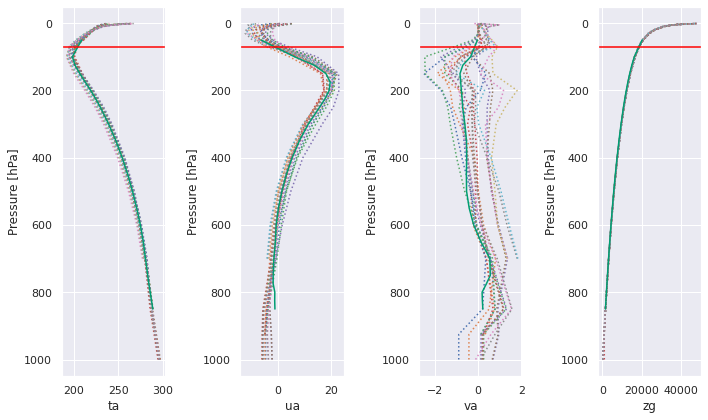

In [28]:
# loop through sites

for idx in range(0,1):

    site_name_folder = d_site_lonlat_data['site_name_folder'][idx]

    d_model = get_PRIMAVERA_seeing_vars(idx)

    fig = plot_seeing_vars_vertical_profile(idx, d_model)

    # save fig
    fig.savefig('./Model_evaluation/seeing_nc/vertical_profile_u_v_t/'+ site_name_folder + '_vertical_profile_u_v_t.png', bbox_inches = 'tight', pad_inches=0.0, dpi=400)

# remember: ua: eastward wind (going to the east (jet stream!)), va: northward wind

# plot Cn2 (possible?)
# calc cn2 out of medians

...


In [29]:
ds_model['HadGEM']['ds_seeing']


NameError: name 'ds_model' is not defined

In [30]:
d_model['HadGEM']['ds_seeing']


<xarray.Dataset>
Dimensions:       (level: 19, time: 1212)
Coordinates:
  * time          (time) object 1950-01-16 00:00:00 ... 2050-12-16 00:00:00
  * level         (level) int64 1000 925 850 700 600 500 400 ... 50 30 20 10 5 1
Data variables:
    ua hist       (time, level) float32 nan nan 1.4038086 ... nan nan nan
    ua present    (time, level) float32 nan nan -1.4111328 ... nan nan nan
    ua future     (time, level) float32 nan nan nan ... 19.796387 34.327637
    ua SSTfuture  (time, level) float32 nan nan nan ... 11.756592 32.712646
    va hist       (time, level) float32 nan nan 0.080078125 ... nan nan nan
    va present    (time, level) float32 nan nan 0.40112305 ... nan nan nan
    va future     (time, level) float32 nan nan nan ... 3.8447266 3.4414062
    va SSTfuture  (time, level) float32 nan nan nan ... 1.4077148 4.368408
    zg hist       (time, level) float32 nan nan 1452.7305 ... nan nan nan
    zg present    (time, level) float32 nan nan 1494.3008 ... nan nan nan
    zg future     (time, level) float32 nan nan nan ... 35456.2 47188.105
    zg SSTfuture  (time, level) float32 nan nan nan ... 35610.867 47335.42
    ta hist       (time, level) float32 nan nan 285.1272 ... nan nan nan
    ta present    (time, level) float32 nan nan 286.0525 ... nan nan nan
    ta future     (time, level) float32 nan nan nan ... 229.18408 260.26343
    ta SSTfuture  (time, level) float32 nan nan nan ... 233.77954 259.3269

In [31]:
d_model['HadGEM']['ds_seeing'].median(dim='time')


<xarray.Dataset>
Dimensions:       (level: 19)
Coordinates:
  * level         (level) int64 1000 925 850 700 600 500 400 ... 50 30 20 10 5 1
Data variables:
    ua hist       (level) float64 nan -4.734 -3.683 ... -8.48 -6.116 -2.463
    ua present    (level) float64 nan -4.693 -4.208 ... -7.407 -4.654 0.647
    ua future     (level) float64 nan -4.732 -3.518 ... -5.961 -4.013 -1.549
    ua SSTfuture  (level) float64 nan -4.702 -3.984 -1.12 ... -5.69 -3.022 1.044
    va hist       (level) float64 nan 0.1507 0.7871 ... -0.01819 0.1826
    va present    (level) float64 nan 0.3295 0.7584 ... -0.04712 0.1501
    va future     (level) float64 nan 0.123 0.781 ... 0.02063 -0.02539 0.1714
    va SSTfuture  (level) float64 nan 0.248 0.6877 ... 0.006714 -0.02551 0.1316
    zg hist       (level) float64 nan nan 1.517e+03 ... 3.581e+04 4.79e+04
    zg present    (level) float64 nan nan 1.526e+03 ... 3.586e+04 4.795e+04
    zg future     (level) float64 nan nan 1.527e+03 ... 3.578e+04 4.767e+04
    zg SSTfuture  (level) float64 nan nan 1.535e+03 ... 3.578e+04 4.765e+04
    ta hist       (level) float64 nan nan 287.7 279.9 ... 231.1 242.6 265.3
    ta present    (level) float64 nan nan 288.1 279.9 ... 231.0 242.2 265.5
    ta future     (level) float64 nan nan 289.2 281.7 ... 227.9 238.3 260.5
    ta SSTfuture  (level) float64 nan nan 289.0 281.1 ... 227.8 238.3 260.4

In [32]:
ds_full['ta hist'].sel(level=pr_levels_list[0])

NameError: name 'ds_full' is not defined

In [33]:
ds_full = d_model['HadGEM']['ds_seeing'].median(dim='time')


In [34]:
ds_full['ta hist'].sel(level=pr_levels_list[0])

<xarray.DataArray 'ta hist' ()>
array(265.32641602)
Coordinates:
    level    int64 1

In [35]:
ds_full.level

<xarray.DataArray 'level' (level: 19)>
array([1000,  925,  850,  700,  600,  500,  400,  300,  250,  200,  150,  100,
         70,   50,   30,   20,   10,    5,    1])
Coordinates:
  * level    (level) int64 1000 925 850 700 600 500 400 ... 70 50 30 20 10 5 1
Attributes:
    units:    hPa

In [36]:
ds_full.level[0]

<xarray.DataArray 'level' ()>
array(1000)
Coordinates:
    level    int64 1000
Attributes:
    units:    hPa

In [37]:
# plot Cn2 (possible?)
# calc cn2 out of medians

T_clim_var = 'ta ' + forcing
U_clim_var = 'ua ' + forcing
V_clim_var = 'va ' + forcing
Z_clim_var = 'zg ' + forcing


# k_factor = climxa.PRIMAVERA_calc_seeing(ds_full, mean_insitu, lon, lat, T_clim_var, U_clim_var, V_clim_var, Z_clim_var, pr_levels_list, site, clim_key, forcing, PRIMAVERA_surface_pressure_value)

pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000

ds_full = d_model['HadGEM']['ds_seeing'].median(dim='time')

J = 0

for i in range(0, len(pr_levels_list)-1):
    # print(pr_levels_list[i])
    T = ds_full[T_clim_var].sel(level=pr_levels_list[i])
    P = ds_full.level[i]
    u_i0 = ds_full[U_clim_var].sel(level=pr_levels_list[i])
    u_i1 = ds_full[U_clim_var].sel(level=pr_levels_list[i+1])
    v_i0 = ds_full[V_clim_var].sel(level=pr_levels_list[i]) 
    v_i1 = ds_full[V_clim_var].sel(level=pr_levels_list[i+1])
    T1 = ds_full[T_clim_var].sel(level=pr_levels_list[i+1])
    P1 = ds_full.level[int(i+1)] 
    df_z_0 = ds_full[Z_clim_var].sel(level=pr_levels_list[i]) # do not divide by g, it is already in m (model data)
    if i == 0:
        df_z_m1 = 0
    else:
        df_z_m1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i-1])
    df_z_p1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i+1])
    # integrate (sum)
    J_add = Cn2_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)

    # test if climxa.Cn2_func() doesn't return NaN
    ds_check = J_add.where(xr.ufuncs.isnan(J_add) != True, drop = True)
    # print(ds_check['time'].size)
    if ds_check['time'].size == 0:
        print('nan array for {}'.format(i))
    else:
        J = J + J_add
    
        # (for Cn2 profile, do not sum over Cn2, but store Cn2 on pressure level dimension)
        # do that!! (and only if J_add is not nan)
        ds_Cn2 = Cn2_profile_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)
        ds_Cn2 = ds_Cn2.assign_coords({"level": pr_levels_list[i]})

        print(f'J = {J}')
        print(f'pressure level = {pr_levels_list[i]}')

        # concatenate DataArrays along new dimension 'level'
        if i == 0:
            ds_Cn2_profile = ds_Cn2
        else:
            ds_Cn2_profile = xr.concat([ds_Cn2_profile, ds_Cn2], 'level')


NameError: name 'Cn2_func' is not defined

In [38]:
# plot Cn2 (possible?)
# calc cn2 out of medians

T_clim_var = 'ta ' + forcing
U_clim_var = 'ua ' + forcing
V_clim_var = 'va ' + forcing
Z_clim_var = 'zg ' + forcing


# k_factor = climxa.PRIMAVERA_calc_seeing(ds_full, mean_insitu, lon, lat, T_clim_var, U_clim_var, V_clim_var, Z_clim_var, pr_levels_list, site, clim_key, forcing, PRIMAVERA_surface_pressure_value)

pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000

ds_full = d_model['HadGEM']['ds_seeing'].median(dim='time')

J = 0

for i in range(0, len(pr_levels_list)-1):
    # print(pr_levels_list[i])
    T = ds_full[T_clim_var].sel(level=pr_levels_list[i])
    P = ds_full.level[i]
    u_i0 = ds_full[U_clim_var].sel(level=pr_levels_list[i])
    u_i1 = ds_full[U_clim_var].sel(level=pr_levels_list[i+1])
    v_i0 = ds_full[V_clim_var].sel(level=pr_levels_list[i]) 
    v_i1 = ds_full[V_clim_var].sel(level=pr_levels_list[i+1])
    T1 = ds_full[T_clim_var].sel(level=pr_levels_list[i+1])
    P1 = ds_full.level[int(i+1)] 
    df_z_0 = ds_full[Z_clim_var].sel(level=pr_levels_list[i]) # do not divide by g, it is already in m (model data)
    if i == 0:
        df_z_m1 = 0
    else:
        df_z_m1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i-1])
    df_z_p1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i+1])
    # integrate (sum)
    J_add = climxa.Cn2_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)

    # test if climxa.Cn2_func() doesn't return NaN
    ds_check = J_add.where(xr.ufuncs.isnan(J_add) != True, drop = True)
    # print(ds_check['time'].size)
    if ds_check['time'].size == 0:
        print('nan array for {}'.format(i))
    else:
        J = J + J_add
    
        # (for Cn2 profile, do not sum over Cn2, but store Cn2 on pressure level dimension)
        # do that!! (and only if J_add is not nan)
        ds_Cn2 = climxa.Cn2_profile_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)
        ds_Cn2 = ds_Cn2.assign_coords({"level": pr_levels_list[i]})

        print(f'J = {J_add}')
        print(f'pressure level = {pr_levels_list[i]}')

        # concatenate DataArrays along new dimension 'level'
        if i == 0:
            ds_Cn2_profile = ds_Cn2
        else:
            ds_Cn2_profile = xr.concat([ds_Cn2_profile, ds_Cn2], 'level')


KeyError: 'time'

In [39]:
# plot Cn2 (possible?)
# calc cn2 out of medians

T_clim_var = 'ta ' + forcing
U_clim_var = 'ua ' + forcing
V_clim_var = 'va ' + forcing
Z_clim_var = 'zg ' + forcing


# k_factor = climxa.PRIMAVERA_calc_seeing(ds_full, mean_insitu, lon, lat, T_clim_var, U_clim_var, V_clim_var, Z_clim_var, pr_levels_list, site, clim_key, forcing, PRIMAVERA_surface_pressure_value)

pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000

ds_full = d_model['HadGEM']['ds_seeing'].median(dim='time')

J = 0

for i in range(0, len(pr_levels_list)-1):
    # print(pr_levels_list[i])
    T = ds_full[T_clim_var].sel(level=pr_levels_list[i])
    P = ds_full.level[i]
    u_i0 = ds_full[U_clim_var].sel(level=pr_levels_list[i])
    u_i1 = ds_full[U_clim_var].sel(level=pr_levels_list[i+1])
    v_i0 = ds_full[V_clim_var].sel(level=pr_levels_list[i]) 
    v_i1 = ds_full[V_clim_var].sel(level=pr_levels_list[i+1])
    T1 = ds_full[T_clim_var].sel(level=pr_levels_list[i+1])
    P1 = ds_full.level[int(i+1)] 
    df_z_0 = ds_full[Z_clim_var].sel(level=pr_levels_list[i]) # do not divide by g, it is already in m (model data)
    if i == 0:
        df_z_m1 = 0
    else:
        df_z_m1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i-1])
    df_z_p1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i+1])
    # integrate (sum)
    J_add = climxa.Cn2_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)

    # test if climxa.Cn2_func() doesn't return NaN
    ds_check = J_add.where(xr.ufuncs.isnan(J_add) != True, drop = True)
    # print(ds_check['time'].size)

    J = J + J_add

    # (for Cn2 profile, do not sum over Cn2, but store Cn2 on pressure level dimension)
    # do that!! (and only if J_add is not nan)
    ds_Cn2 = climxa.Cn2_profile_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)
    ds_Cn2 = ds_Cn2.assign_coords({"level": pr_levels_list[i]})

    print(f'J = {J_add}')
    print(f'pressure level = {pr_levels_list[i]}')

    # concatenate DataArrays along new dimension 'level'
    if i == 0:
        ds_Cn2_profile = ds_Cn2
    else:
        ds_Cn2_profile = xr.concat([ds_Cn2_profile, ds_Cn2], 'level')


J = <xarray.DataArray ()>
array(8.84472556e-16)
pressure level = 1
J = <xarray.DataArray ()>
array(2.0663523e-16)
pressure level = 5
J = <xarray.DataArray ()>
array(4.1817273e-16)
pressure level = 10
J = <xarray.DataArray ()>
array(9.50900582e-17)
pressure level = 20
J = <xarray.DataArray ()>
array(3.86017989e-16)
pressure level = 30
J = <xarray.DataArray ()>
array(2.4629008e-15)
pressure level = 50
J = <xarray.DataArray ()>
array(1.51933369e-14)
pressure level = 70
J = <xarray.DataArray ()>
array(1.30049956e-14)
pressure level = 100
J = <xarray.DataArray ()>
array(3.85274177e-16)
Coordinates:
    level    int64 200
pressure level = 150
J = <xarray.DataArray ()>
array(3.13399636e-15)
Coordinates:
    level    int64 200
pressure level = 200
J = <xarray.DataArray ()>
array(2.87127016e-15)
pressure level = 250
J = <xarray.DataArray ()>
array(1.40024418e-15)
pressure level = 300
J = <xarray.DataArray ()>
array(2.33796866e-16)
pressure level = 400
J = <xarray.DataArray ()>
array(9.39215031e

In [40]:
ds_Cn2


<xarray.DataArray ()>
array(nan)
Coordinates:
    level    int64 925

In [41]:
ds_Cn2_profile


<xarray.DataArray (level: 18)>
array([7.44863343e-20, 2.48817352e-20, 8.99683154e-20, 2.66148012e-20,
       1.34349544e-19, 9.52962834e-19, 7.40232489e-18, 5.74675964e-18,
       1.81855072e-19, 1.90979069e-18, 2.10213657e-18, 8.36881525e-19,
       1.23192182e-19, 5.94952136e-20, 1.08262376e-20, 2.78519500e-20,
                  nan,            nan])
Coordinates:
  * level    (level) int64 1 5 10 20 30 50 70 ... 300 400 500 600 700 850 925

In [42]:
# plot Cn2 (possible?)
# calc cn2 out of medians

T_clim_var = 'ta ' + forcing
U_clim_var = 'ua ' + forcing
V_clim_var = 'va ' + forcing
Z_clim_var = 'zg ' + forcing


# k_factor = climxa.PRIMAVERA_calc_seeing(ds_full, mean_insitu, lon, lat, T_clim_var, U_clim_var, V_clim_var, Z_clim_var, pr_levels_list, site, clim_key, forcing, PRIMAVERA_surface_pressure_value)

pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000

ds_full = d_model['HadGEM']['ds_seeing'].median(dim='time')

J = 0

ls_pr = []
ls_cn2 = []

for i in range(0, len(pr_levels_list)-1):
    # print(pr_levels_list[i])
    T = ds_full[T_clim_var].sel(level=pr_levels_list[i])
    P = ds_full.level[i]
    u_i0 = ds_full[U_clim_var].sel(level=pr_levels_list[i])
    u_i1 = ds_full[U_clim_var].sel(level=pr_levels_list[i+1])
    v_i0 = ds_full[V_clim_var].sel(level=pr_levels_list[i]) 
    v_i1 = ds_full[V_clim_var].sel(level=pr_levels_list[i+1])
    T1 = ds_full[T_clim_var].sel(level=pr_levels_list[i+1])
    P1 = ds_full.level[int(i+1)] 
    df_z_0 = ds_full[Z_clim_var].sel(level=pr_levels_list[i]) # do not divide by g, it is already in m (model data)
    if i == 0:
        df_z_m1 = 0
    else:
        df_z_m1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i-1])
    df_z_p1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i+1])
    # integrate (sum)
    J_add = climxa.Cn2_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)

    # test if climxa.Cn2_func() doesn't return NaN
    ds_check = J_add.where(xr.ufuncs.isnan(J_add) != True, drop = True)
    # print(ds_check['time'].size)

    J = J + J_add

    # (for Cn2 profile, do not sum over Cn2, but store Cn2 on pressure level dimension)
    # do that!! (and only if J_add is not nan)
    ds_Cn2 = climxa.Cn2_profile_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)
    ds_Cn2 = ds_Cn2.assign_coords({"level": pr_levels_list[i]})

    print(f'Cn2 = {ds_Cn2}')
    print(f'pressure level = {pr_levels_list[i]}')

    # concatenate DataArrays along new dimension 'level'
    if i == 0:
        ds_Cn2_profile = ds_Cn2
    else:
        ds_Cn2_profile = xr.concat([ds_Cn2_profile, ds_Cn2], 'level')

    # just use list to append



Cn2 = <xarray.DataArray ()>
array(7.44863343e-20)
Coordinates:
    level    int64 1
pressure level = 1
Cn2 = <xarray.DataArray ()>
array(2.48817352e-20)
Coordinates:
    level    int64 5
pressure level = 5
Cn2 = <xarray.DataArray ()>
array(8.99683154e-20)
Coordinates:
    level    int64 10
pressure level = 10
Cn2 = <xarray.DataArray ()>
array(2.66148012e-20)
Coordinates:
    level    int64 20
pressure level = 20
Cn2 = <xarray.DataArray ()>
array(1.34349544e-19)
Coordinates:
    level    int64 30
pressure level = 30
Cn2 = <xarray.DataArray ()>
array(9.52962834e-19)
Coordinates:
    level    int64 50
pressure level = 50
Cn2 = <xarray.DataArray ()>
array(7.40232489e-18)
Coordinates:
    level    int64 70
pressure level = 70
Cn2 = <xarray.DataArray ()>
array(5.74675964e-18)
Coordinates:
    level    int64 100
pressure level = 100
Cn2 = <xarray.DataArray ()>
array(1.81855072e-19)
Coordinates:
    level    int64 150
pressure level = 150
Cn2 = <xarray.DataArray ()>
array(1.90979069e-18)
Coord

In [43]:
ds_Cn2.values


array(nan)

In [44]:
# plot Cn2 (possible?)
# calc cn2 out of medians

T_clim_var = 'ta ' + forcing
U_clim_var = 'ua ' + forcing
V_clim_var = 'va ' + forcing
Z_clim_var = 'zg ' + forcing


# k_factor = climxa.PRIMAVERA_calc_seeing(ds_full, mean_insitu, lon, lat, T_clim_var, U_clim_var, V_clim_var, Z_clim_var, pr_levels_list, site, clim_key, forcing, PRIMAVERA_surface_pressure_value)

pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000

ds_full = d_model['HadGEM']['ds_seeing'].median(dim='time')

J = 0

ls_pr = []
ls_cn2 = []

for i in range(0, len(pr_levels_list)-1):
    # print(pr_levels_list[i])
    T = ds_full[T_clim_var].sel(level=pr_levels_list[i])
    P = ds_full.level[i]
    u_i0 = ds_full[U_clim_var].sel(level=pr_levels_list[i])
    u_i1 = ds_full[U_clim_var].sel(level=pr_levels_list[i+1])
    v_i0 = ds_full[V_clim_var].sel(level=pr_levels_list[i]) 
    v_i1 = ds_full[V_clim_var].sel(level=pr_levels_list[i+1])
    T1 = ds_full[T_clim_var].sel(level=pr_levels_list[i+1])
    P1 = ds_full.level[int(i+1)] 
    df_z_0 = ds_full[Z_clim_var].sel(level=pr_levels_list[i]) # do not divide by g, it is already in m (model data)
    if i == 0:
        df_z_m1 = 0
    else:
        df_z_m1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i-1])
    df_z_p1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i+1])
    # integrate (sum)
    J_add = climxa.Cn2_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)

    # test if climxa.Cn2_func() doesn't return NaN
    ds_check = J_add.where(xr.ufuncs.isnan(J_add) != True, drop = True)
    # print(ds_check['time'].size)

    J = J + J_add

    # (for Cn2 profile, do not sum over Cn2, but store Cn2 on pressure level dimension)
    # do that!! (and only if J_add is not nan)
    ds_Cn2 = climxa.Cn2_profile_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)
    ls_pr.append(pr_levels_list[i])
    ls_cn2.append(ds_Cn2.values)

    # ds_Cn2 = ds_Cn2.assign_coords({"level": pr_levels_list[i]})



    print(f'Cn2 = {ds_Cn2}')
    print(f'pressure level = {pr_levels_list[i]}')

    # concatenate DataArrays along new dimension 'level'
    if i == 0:
        ds_Cn2_profile = ds_Cn2
    else:
        ds_Cn2_profile = xr.concat([ds_Cn2_profile, ds_Cn2], 'level')

    # just use list to append



Cn2 = <xarray.DataArray ()>
array(7.44863343e-20)
pressure level = 1
Cn2 = <xarray.DataArray ()>
array(2.48817352e-20)
pressure level = 5
Cn2 = <xarray.DataArray ()>
array(8.99683154e-20)
pressure level = 10
Cn2 = <xarray.DataArray ()>
array(2.66148012e-20)
pressure level = 20
Cn2 = <xarray.DataArray ()>
array(1.34349544e-19)
pressure level = 30
Cn2 = <xarray.DataArray ()>
array(9.52962834e-19)
pressure level = 50
Cn2 = <xarray.DataArray ()>
array(7.40232489e-18)
pressure level = 70
Cn2 = <xarray.DataArray ()>
array(5.74675964e-18)
pressure level = 100
Cn2 = <xarray.DataArray ()>
array(1.81855072e-19)
Coordinates:
    level    int64 200
pressure level = 150


ValueError: Variables {'level'} are coordinates in some datasets but not others.

In [45]:
# plot Cn2 (possible?)
# calc cn2 out of medians

T_clim_var = 'ta ' + forcing
U_clim_var = 'ua ' + forcing
V_clim_var = 'va ' + forcing
Z_clim_var = 'zg ' + forcing


# k_factor = climxa.PRIMAVERA_calc_seeing(ds_full, mean_insitu, lon, lat, T_clim_var, U_clim_var, V_clim_var, Z_clim_var, pr_levels_list, site, clim_key, forcing, PRIMAVERA_surface_pressure_value)

pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000

ds_full = d_model['HadGEM']['ds_seeing'].median(dim='time')

J = 0

ls_pr = []
ls_cn2 = []

for i in range(0, len(pr_levels_list)-1):
    # print(pr_levels_list[i])
    T = ds_full[T_clim_var].sel(level=pr_levels_list[i])
    P = ds_full.level[i]
    u_i0 = ds_full[U_clim_var].sel(level=pr_levels_list[i])
    u_i1 = ds_full[U_clim_var].sel(level=pr_levels_list[i+1])
    v_i0 = ds_full[V_clim_var].sel(level=pr_levels_list[i]) 
    v_i1 = ds_full[V_clim_var].sel(level=pr_levels_list[i+1])
    T1 = ds_full[T_clim_var].sel(level=pr_levels_list[i+1])
    P1 = ds_full.level[int(i+1)] 
    df_z_0 = ds_full[Z_clim_var].sel(level=pr_levels_list[i]) # do not divide by g, it is already in m (model data)
    if i == 0:
        df_z_m1 = 0
    else:
        df_z_m1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i-1])
    df_z_p1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i+1])
    # integrate (sum)
    J_add = climxa.Cn2_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)

    # test if climxa.Cn2_func() doesn't return NaN
    ds_check = J_add.where(xr.ufuncs.isnan(J_add) != True, drop = True)
    # print(ds_check['time'].size)

    J = J + J_add

    # (for Cn2 profile, do not sum over Cn2, but store Cn2 on pressure level dimension)
    # do that!! (and only if J_add is not nan)
    ds_Cn2 = climxa.Cn2_profile_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)
    ls_pr.append(pr_levels_list[i])
    ls_cn2.append(ds_Cn2.values)

    # ds_Cn2 = ds_Cn2.assign_coords({"level": pr_levels_list[i]})



    # print(f'Cn2 = {ds_Cn2}')
    # print(f'pressure level = {pr_levels_list[i]}')

    # # concatenate DataArrays along new dimension 'level'
    # if i == 0:
    #     ds_Cn2_profile = ds_Cn2
    # else:
    #     ds_Cn2_profile = xr.concat([ds_Cn2_profile, ds_Cn2], 'level')

    # just use list to append



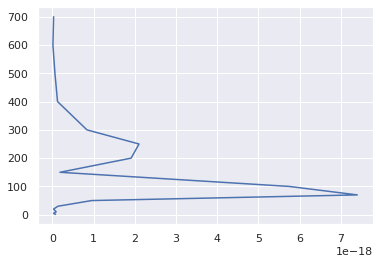

In [46]:
plt.plot(ls_cn2, ls_pr)

In [47]:
ds_ERA5_median


<xarray.Dataset>
Dimensions:    (level: 24)
Coordinates:
    latitude   float32 31.0
    longitude  float32 -115.5
  * level      (level) int64 50 100 125 150 175 200 ... 775 800 825 850 875 900
Data variables:
    v          (level) float32 -0.26568398 1.7164274 ... -0.14265883 -0.16809684
    u          (level) float32 -1.253613 11.955747 ... 0.34849018 0.37385225
    t          (level) float32 211.14272 204.52087 ... 291.34076 292.98694
    z          (level) float32 202204.31 161184.5 ... 12376.283 10028.156

In [49]:
ds_ERA5_median.level

<xarray.DataArray 'level' (level: 24)>
array([ 50, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400, 450, 500, 550,
       600, 650, 700, 750, 775, 800, 825, 850, 875, 900])
Coordinates:
    latitude   float32 31.0
    longitude  float32 -115.5
  * level      (level) int64 50 100 125 150 175 200 ... 775 800 825 850 875 900

In [50]:
# plot Cn2 (possible?)
# calc cn2 out of medians




# k_factor = climxa.PRIMAVERA_calc_seeing(ds_full, mean_insitu, lon, lat, T_clim_var, U_clim_var, V_clim_var, Z_clim_var, pr_levels_list, site, clim_key, forcing, PRIMAVERA_surface_pressure_value)


# PRIMAVERA

# ds_full = d_model['HadGEM']['ds_seeing'].median(dim='time')
# pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000

# forcing = 'hist'

# T_clim_var = 'ta ' + forcing
# U_clim_var = 'ua ' + forcing
# V_clim_var = 'va ' + forcing
# Z_clim_var = 'zg ' + forcing

# ERA5
ds_full = ds_ERA5_median

pr_levels_list = list(ds_ERA5_median.level)

T_clim_var = 't'
U_clim_var = 'u'
V_clim_var = 'v'
Z_clim_var = 'z'

J = 0

ls_pr = []
ls_cn2 = []

for i in range(0, len(pr_levels_list)-1):
    # print(pr_levels_list[i])
    T = ds_full[T_clim_var].sel(level=pr_levels_list[i])
    P = ds_full.level[i]
    u_i0 = ds_full[U_clim_var].sel(level=pr_levels_list[i])
    u_i1 = ds_full[U_clim_var].sel(level=pr_levels_list[i+1])
    v_i0 = ds_full[V_clim_var].sel(level=pr_levels_list[i]) 
    v_i1 = ds_full[V_clim_var].sel(level=pr_levels_list[i+1])
    T1 = ds_full[T_clim_var].sel(level=pr_levels_list[i+1])
    P1 = ds_full.level[int(i+1)] 
    df_z_0 = ds_full[Z_clim_var].sel(level=pr_levels_list[i]) # do not divide by g, it is already in m (model data)
    if i == 0:
        df_z_m1 = 0
    else:
        df_z_m1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i-1])
    df_z_p1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i+1])
    # integrate (sum)
    J_add = climxa.Cn2_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)

    # test if climxa.Cn2_func() doesn't return NaN
    ds_check = J_add.where(xr.ufuncs.isnan(J_add) != True, drop = True)
    # print(ds_check['time'].size)

    J = J + J_add

    # (for Cn2 profile, do not sum over Cn2, but store Cn2 on pressure level dimension)
    # do that!! (and only if J_add is not nan)
    ds_Cn2 = climxa.Cn2_profile_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)
    ls_pr.append(pr_levels_list[i])
    ls_cn2.append(ds_Cn2.values)

    # ds_Cn2 = ds_Cn2.assign_coords({"level": pr_levels_list[i]})



    # print(f'Cn2 = {ds_Cn2}')
    # print(f'pressure level = {pr_levels_list[i]}')

    # # concatenate DataArrays along new dimension 'level'
    # if i == 0:
    #     ds_Cn2_profile = ds_Cn2
    # else:
    #     ds_Cn2_profile = xr.concat([ds_Cn2_profile, ds_Cn2], 'level')

    # just use list to append



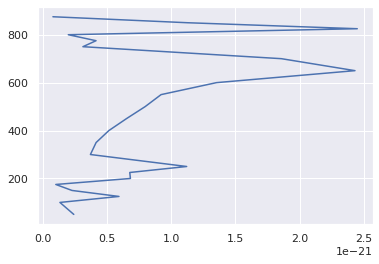

In [51]:
plt.plot(ls_cn2, ls_pr)

In [55]:
# plot Cn2 (possible?)
# calc cn2 out of medians




# k_factor = climxa.PRIMAVERA_calc_seeing(ds_full, mean_insitu, lon, lat, T_clim_var, U_clim_var, V_clim_var, Z_clim_var, pr_levels_list, site, clim_key, forcing, PRIMAVERA_surface_pressure_value)


# PRIMAVERA

# ds_full = d_model['HadGEM']['ds_seeing'].median(dim='time')
# pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000

# forcing = 'hist'

# T_clim_var = 'ta ' + forcing
# U_clim_var = 'ua ' + forcing
# V_clim_var = 'va ' + forcing
# Z_clim_var = 'zg ' + forcing

# ERA5
ds_full = ds_ERA5_median

pr_levels_list = list(ds_ERA5_median.level.values)

T_clim_var = 't'
U_clim_var = 'u'
V_clim_var = 'v'
Z_clim_var = 'z'

J = 0

ls_pr = []
ls_cn2 = []

for i in range(0, len(pr_levels_list)-1):
    # print(pr_levels_list[i])
    T = ds_full[T_clim_var].sel(level=pr_levels_list[i])
    P = ds_full.level[i]
    u_i0 = ds_full[U_clim_var].sel(level=pr_levels_list[i])
    u_i1 = ds_full[U_clim_var].sel(level=pr_levels_list[i+1])
    v_i0 = ds_full[V_clim_var].sel(level=pr_levels_list[i]) 
    v_i1 = ds_full[V_clim_var].sel(level=pr_levels_list[i+1])
    T1 = ds_full[T_clim_var].sel(level=pr_levels_list[i+1])
    P1 = ds_full.level[int(i+1)] 
    df_z_0 = ds_full[Z_clim_var].sel(level=pr_levels_list[i]) # do not divide by g, it is already in m (model data)
    if i == 0:
        df_z_m1 = 0
    else:
        df_z_m1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i-1])
    df_z_p1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i+1])
    # integrate (sum)
    J_add = climxa.Cn2_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)

    # test if climxa.Cn2_func() doesn't return NaN
    ds_check = J_add.where(xr.ufuncs.isnan(J_add) != True, drop = True)
    # print(ds_check['time'].size)

    J = J + J_add

    # (for Cn2 profile, do not sum over Cn2, but store Cn2 on pressure level dimension)
    # do that!! (and only if J_add is not nan)
    ds_Cn2 = climxa.Cn2_profile_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)
    ls_pr.append(pr_levels_list[i])
    ls_cn2.append(ds_Cn2.values)

    # ds_Cn2 = ds_Cn2.assign_coords({"level": pr_levels_list[i]})



    # print(f'Cn2 = {ds_Cn2}')
    # print(f'pressure level = {pr_levels_list[i]}')

    # # concatenate DataArrays along new dimension 'level'
    # if i == 0:
    #     ds_Cn2_profile = ds_Cn2
    # else:
    #     ds_Cn2_profile = xr.concat([ds_Cn2_profile, ds_Cn2], 'level')

    # just use list to append



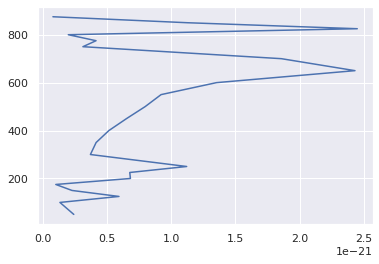

In [56]:
plt.plot(ls_cn2, ls_pr)

In [58]:
list(ds_ERA5_median.level.values)

[50,
 100,
 125,
 150,
 175,
 200,
 225,
 250,
 300,
 350,
 400,
 450,
 500,
 550,
 600,
 650,
 700,
 750,
 775,
 800,
 825,
 850,
 875,
 900]

In [59]:
# plot Cn2 (possible?)
# calc cn2 out of medians




# k_factor = climxa.PRIMAVERA_calc_seeing(ds_full, mean_insitu, lon, lat, T_clim_var, U_clim_var, V_clim_var, Z_clim_var, pr_levels_list, site, clim_key, forcing, PRIMAVERA_surface_pressure_value)


# PRIMAVERA

# ds_full = d_model['HadGEM']['ds_seeing'].median(dim='time')
# pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000

# forcing = 'hist'

# T_clim_var = 'ta ' + forcing
# U_clim_var = 'ua ' + forcing
# V_clim_var = 'va ' + forcing
# Z_clim_var = 'zg ' + forcing

# ERA5
ds_full = ds_ERA5_median

pr_levels_list = [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850] # , 925, 1000
# list(ds_ERA5_median.level.values)

T_clim_var = 't'
U_clim_var = 'u'
V_clim_var = 'v'
Z_clim_var = 'z'

J = 0

ls_pr = []
ls_cn2 = []

for i in range(0, len(pr_levels_list)-1):
    # print(pr_levels_list[i])
    T = ds_full[T_clim_var].sel(level=pr_levels_list[i])
    P = ds_full.level[i]
    u_i0 = ds_full[U_clim_var].sel(level=pr_levels_list[i])
    u_i1 = ds_full[U_clim_var].sel(level=pr_levels_list[i+1])
    v_i0 = ds_full[V_clim_var].sel(level=pr_levels_list[i]) 
    v_i1 = ds_full[V_clim_var].sel(level=pr_levels_list[i+1])
    T1 = ds_full[T_clim_var].sel(level=pr_levels_list[i+1])
    P1 = ds_full.level[int(i+1)] 
    df_z_0 = ds_full[Z_clim_var].sel(level=pr_levels_list[i]) # do not divide by g, it is already in m (model data)
    if i == 0:
        df_z_m1 = 0
    else:
        df_z_m1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i-1])
    df_z_p1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i+1])
    # integrate (sum)
    J_add = climxa.Cn2_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)

    # test if climxa.Cn2_func() doesn't return NaN
    ds_check = J_add.where(xr.ufuncs.isnan(J_add) != True, drop = True)
    # print(ds_check['time'].size)

    J = J + J_add

    # (for Cn2 profile, do not sum over Cn2, but store Cn2 on pressure level dimension)
    # do that!! (and only if J_add is not nan)
    ds_Cn2 = climxa.Cn2_profile_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)
    ls_pr.append(pr_levels_list[i])
    ls_cn2.append(ds_Cn2.values)

    # ds_Cn2 = ds_Cn2.assign_coords({"level": pr_levels_list[i]})



    # print(f'Cn2 = {ds_Cn2}')
    # print(f'pressure level = {pr_levels_list[i]}')

    # # concatenate DataArrays along new dimension 'level'
    # if i == 0:
    #     ds_Cn2_profile = ds_Cn2
    # else:
    #     ds_Cn2_profile = xr.concat([ds_Cn2_profile, ds_Cn2], 'level')

    # just use list to append



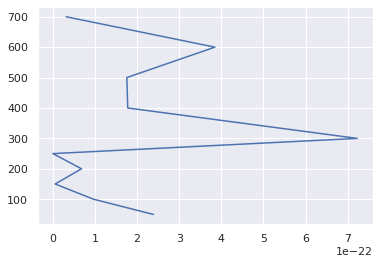

In [60]:
plt.plot(ls_cn2, ls_pr)

In [61]:
# plot Cn2 (possible?)
# calc cn2 out of medians




# k_factor = climxa.PRIMAVERA_calc_seeing(ds_full, mean_insitu, lon, lat, T_clim_var, U_clim_var, V_clim_var, Z_clim_var, pr_levels_list, site, clim_key, forcing, PRIMAVERA_surface_pressure_value)


# PRIMAVERA

ds_full = d_model['HadGEM']['ds_seeing'].median(dim='time')
# pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000

forcing = 'hist'

T_clim_var = 'ta ' + forcing
U_clim_var = 'ua ' + forcing
V_clim_var = 'va ' + forcing
Z_clim_var = 'zg ' + forcing

# ERA5
# ds_full = ds_ERA5_median

# list(ds_ERA5_median.level.values)

# T_clim_var = 't'
# U_clim_var = 'u'
# V_clim_var = 'v'
# Z_clim_var = 'z'

pr_levels_list = [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850] # , 925, 1000


J = 0

ls_pr = []
ls_cn2 = []

for i in range(0, len(pr_levels_list)-1):
    # print(pr_levels_list[i])
    T = ds_full[T_clim_var].sel(level=pr_levels_list[i])
    P = ds_full.level[i]
    u_i0 = ds_full[U_clim_var].sel(level=pr_levels_list[i])
    u_i1 = ds_full[U_clim_var].sel(level=pr_levels_list[i+1])
    v_i0 = ds_full[V_clim_var].sel(level=pr_levels_list[i]) 
    v_i1 = ds_full[V_clim_var].sel(level=pr_levels_list[i+1])
    T1 = ds_full[T_clim_var].sel(level=pr_levels_list[i+1])
    P1 = ds_full.level[int(i+1)] 
    df_z_0 = ds_full[Z_clim_var].sel(level=pr_levels_list[i]) # do not divide by g, it is already in m (model data)
    if i == 0:
        df_z_m1 = 0
    else:
        df_z_m1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i-1])
    df_z_p1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i+1])
    # integrate (sum)
    J_add = climxa.Cn2_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)

    # test if climxa.Cn2_func() doesn't return NaN
    ds_check = J_add.where(xr.ufuncs.isnan(J_add) != True, drop = True)
    # print(ds_check['time'].size)

    J = J + J_add

    # (for Cn2 profile, do not sum over Cn2, but store Cn2 on pressure level dimension)
    # do that!! (and only if J_add is not nan)
    ds_Cn2 = climxa.Cn2_profile_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)
    ls_pr.append(pr_levels_list[i])
    ls_cn2.append(ds_Cn2.values)

    # ds_Cn2 = ds_Cn2.assign_coords({"level": pr_levels_list[i]})



    # print(f'Cn2 = {ds_Cn2}')
    # print(f'pressure level = {pr_levels_list[i]}')

    # # concatenate DataArrays along new dimension 'level'
    # if i == 0:
    #     ds_Cn2_profile = ds_Cn2
    # else:
    #     ds_Cn2_profile = xr.concat([ds_Cn2_profile, ds_Cn2], 'level')

    # just use list to append



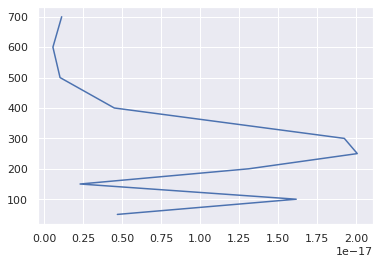

In [62]:
plt.plot(ls_cn2, ls_pr)

In [63]:
ds_full

<xarray.Dataset>
Dimensions:       (level: 19)
Coordinates:
  * level         (level) int64 1000 925 850 700 600 500 400 ... 50 30 20 10 5 1
Data variables:
    ua hist       (level) float64 nan -4.734 -3.683 ... -8.48 -6.116 -2.463
    ua present    (level) float64 nan -4.693 -4.208 ... -7.407 -4.654 0.647
    ua future     (level) float64 nan -4.732 -3.518 ... -5.961 -4.013 -1.549
    ua SSTfuture  (level) float64 nan -4.702 -3.984 -1.12 ... -5.69 -3.022 1.044
    va hist       (level) float64 nan 0.1507 0.7871 ... -0.01819 0.1826
    va present    (level) float64 nan 0.3295 0.7584 ... -0.04712 0.1501
    va future     (level) float64 nan 0.123 0.781 ... 0.02063 -0.02539 0.1714
    va SSTfuture  (level) float64 nan 0.248 0.6877 ... 0.006714 -0.02551 0.1316
    zg hist       (level) float64 nan nan 1.517e+03 ... 3.581e+04 4.79e+04
    zg present    (level) float64 nan nan 1.526e+03 ... 3.586e+04 4.795e+04
    zg future     (level) float64 nan nan 1.527e+03 ... 3.578e+04 4.767e+04
    zg SSTfuture  (level) float64 nan nan 1.535e+03 ... 3.578e+04 4.765e+04
    ta hist       (level) float64 nan nan 287.7 279.9 ... 231.1 242.6 265.3
    ta present    (level) float64 nan nan 288.1 279.9 ... 231.0 242.2 265.5
    ta future     (level) float64 nan nan 289.2 281.7 ... 227.9 238.3 260.5
    ta SSTfuture  (level) float64 nan nan 289.0 281.1 ... 227.8 238.3 260.4

In [64]:
ds_full['ua hist']

<xarray.DataArray 'ua hist' (level: 19)>
array([        nan, -4.734375  , -3.68310547, -0.57348633,  0.69921875,
        3.01867676,  7.05700684, 13.26586914, 17.421875  , 20.5333252 ,
       20.5625    ,  8.57287598, -1.80163574, -6.06494141, -9.40612793,
       -9.82092285, -8.48022461, -6.11633301, -2.46252441])
Coordinates:
  * level    (level) int64 1000 925 850 700 600 500 400 ... 70 50 30 20 10 5 1

In [65]:
ds_ERA5_median['u']

<xarray.DataArray 'u' (level: 24)>
array([-1.253613  , 11.955747  , 16.98988   , 20.118042  , 21.344091  ,
       20.863682  , 19.30561   , 17.595469  , 14.419203  , 12.021363  ,
       10.029745  ,  8.310075  ,  6.8288317 ,  5.570106  ,  4.5230327 ,
        3.4563618 ,  2.1462152 ,  1.2208811 ,  1.0100577 ,  0.95928025,
        0.959328  ,  0.6032784 ,  0.34849018,  0.37385225], dtype=float32)
Coordinates:
    latitude   float32 31.0
    longitude  float32 -115.5
  * level      (level) int64 50 100 125 150 175 200 ... 775 800 825 850 875 900

In [66]:
site_name_folder

'MaunaKea'

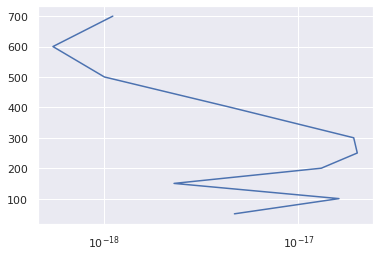

In [67]:
plt.plot(ls_cn2, ls_pr)
plt.xscale('log')

In [68]:
# plot Cn2 (possible?)
# calc cn2 out of medians


PRIMAVERA = False
ERA5 = True

# k_factor = climxa.PRIMAVERA_calc_seeing(ds_full, mean_insitu, lon, lat, T_clim_var, U_clim_var, V_clim_var, Z_clim_var, pr_levels_list, site, clim_key, forcing, PRIMAVERA_surface_pressure_value)


# PRIMAVERA
if PRIMAVERA:
    ds_full = d_model['HadGEM']['ds_seeing'].median(dim='time')
    # pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000

    forcing = 'hist'

    T_clim_var = 'ta ' + forcing
    U_clim_var = 'ua ' + forcing
    V_clim_var = 'va ' + forcing
    Z_clim_var = 'zg ' + forcing

# ERA5
if ERA5:
    ds_full = ds_ERA5_median

    list(ds_ERA5_median.level.values)

    T_clim_var = 't'
    U_clim_var = 'u'
    V_clim_var = 'v'
    Z_clim_var = 'z'

pr_levels_list = [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850] # , 925, 1000


J = 0

ls_pr = []
ls_cn2 = []

for i in range(0, len(pr_levels_list)-1):
    # print(pr_levels_list[i])
    T = ds_full[T_clim_var].sel(level=pr_levels_list[i])
    P = ds_full.level[i]
    u_i0 = ds_full[U_clim_var].sel(level=pr_levels_list[i])
    u_i1 = ds_full[U_clim_var].sel(level=pr_levels_list[i+1])
    v_i0 = ds_full[V_clim_var].sel(level=pr_levels_list[i]) 
    v_i1 = ds_full[V_clim_var].sel(level=pr_levels_list[i+1])
    T1 = ds_full[T_clim_var].sel(level=pr_levels_list[i+1])
    P1 = ds_full.level[int(i+1)] 
    df_z_0 = ds_full[Z_clim_var].sel(level=pr_levels_list[i]) # do not divide by g, it is already in m (model data)
    if i == 0:
        df_z_m1 = 0
    else:
        df_z_m1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i-1])
    df_z_p1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i+1])
    # integrate (sum)
    J_add = climxa.Cn2_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)

    # test if climxa.Cn2_func() doesn't return NaN
    ds_check = J_add.where(xr.ufuncs.isnan(J_add) != True, drop = True)
    # print(ds_check['time'].size)

    J = J + J_add

    # (for Cn2 profile, do not sum over Cn2, but store Cn2 on pressure level dimension)
    # do that!! (and only if J_add is not nan)
    ds_Cn2 = climxa.Cn2_profile_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)
    ls_pr.append(pr_levels_list[i])
    ls_cn2.append(ds_Cn2.values)

    # ds_Cn2 = ds_Cn2.assign_coords({"level": pr_levels_list[i]})



    # print(f'Cn2 = {ds_Cn2}')
    # print(f'pressure level = {pr_levels_list[i]}')

    # # concatenate DataArrays along new dimension 'level'
    # if i == 0:
    #     ds_Cn2_profile = ds_Cn2
    # else:
    #     ds_Cn2_profile = xr.concat([ds_Cn2_profile, ds_Cn2], 'level')

    # just use list to append



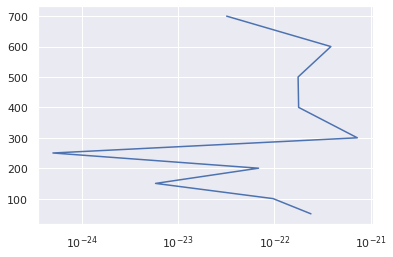

In [69]:
plt.plot(ls_cn2, ls_pr)
plt.xscale('log')

In [71]:
ds_full


<xarray.Dataset>
Dimensions:    (level: 24)
Coordinates:
    latitude   float32 31.0
    longitude  float32 -115.5
  * level      (level) int64 50 100 125 150 175 200 ... 775 800 825 850 875 900
Data variables:
    v          (level) float32 -0.26568398 1.7164274 ... -0.14265883 -0.16809684
    u          (level) float32 -1.253613 11.955747 ... 0.34849018 0.37385225
    t          (level) float32 211.14272 204.52087 ... 291.34076 292.98694
    z          (level) float32 202204.31 161184.5 ... 12376.283 10028.156

In [72]:
ds_ERA5_median


<xarray.Dataset>
Dimensions:    (level: 24)
Coordinates:
    latitude   float32 31.0
    longitude  float32 -115.5
  * level      (level) int64 50 100 125 150 175 200 ... 775 800 825 850 875 900
Data variables:
    v          (level) float32 -0.26568398 1.7164274 ... -0.14265883 -0.16809684
    u          (level) float32 -1.253613 11.955747 ... 0.34849018 0.37385225
    t          (level) float32 211.14272 204.52087 ... 291.34076 292.98694
    z          (level) float32 202204.31 161184.5 ... 12376.283 10028.156

San Pedro Martir (Mexico)
reading data for HadGEM, SPM
reading data for EC-Earth, SPM
reading data for CNRM, SPM
reading data for MPI, SPM
reading data for CMCC, SPM
reading data for ECMWF, SPM
0
1
2
3


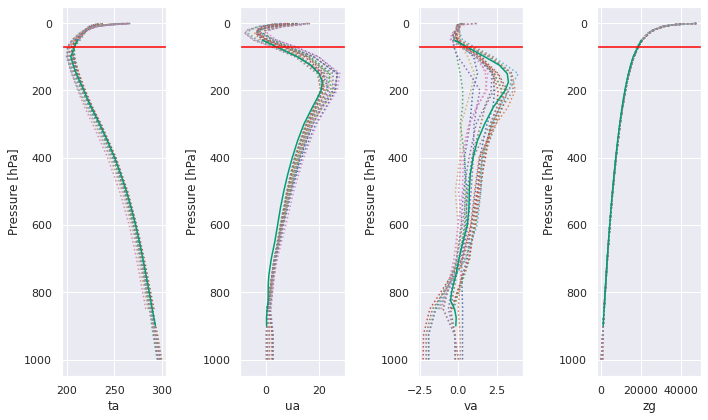

In [74]:
# loop through sites

for idx in range(7,8):

    site_name_folder = d_site_lonlat_data['site_name_folder'][idx]

    d_model = get_PRIMAVERA_seeing_vars(idx)

    fig = plot_seeing_vars_vertical_profile(idx, d_model)

    # save fig
    fig.savefig('./Model_evaluation/seeing_nc/vertical_profile_u_v_t/'+ site_name_folder + '_vertical_profile_u_v_t.png', bbox_inches = 'tight', pad_inches=0.0, dpi=400)

# remember: ua: eastward wind (going to the east (jet stream!)), va: northward wind


Mauna Kea (USA)
reading data for HadGEM, MaunaKea
reading data for EC-Earth, MaunaKea
reading data for CNRM, MaunaKea
reading data for MPI, MaunaKea
reading data for CMCC, MaunaKea
reading data for ECMWF, MaunaKea
0
1
2
3
Cerro Paranal (Chile)
reading data for HadGEM, Paranal
reading data for EC-Earth, Paranal
reading data for CNRM, Paranal
reading data for MPI, Paranal
reading data for CMCC, Paranal
reading data for ECMWF, Paranal
0
1
2
3
La Silla (Chile)
reading data for HadGEM, La_Silla
reading data for EC-Earth, La_Silla
reading data for CNRM, La_Silla
reading data for MPI, La_Silla
reading data for CMCC, La_Silla
reading data for ECMWF, La_Silla
0
1
2
3
Cerro Tololo (Chile)
reading data for HadGEM, Cerro_Tololo
reading data for EC-Earth, Cerro_Tololo
reading data for CNRM, Cerro_Tololo
reading data for MPI, Cerro_Tololo
reading data for CMCC, Cerro_Tololo
reading data for ECMWF, Cerro_Tololo
0
1
2
3
La Palma (Spain)
reading data for HadGEM, La_Palma
reading data for EC-Earth, La_P

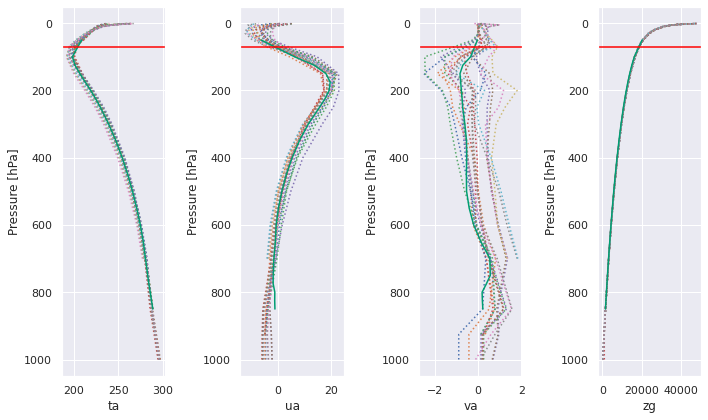

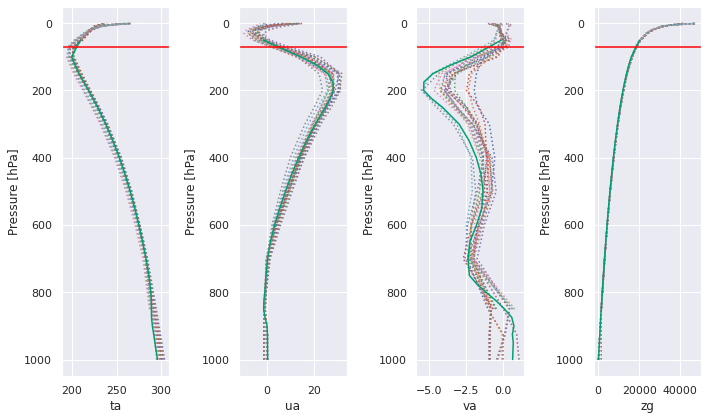

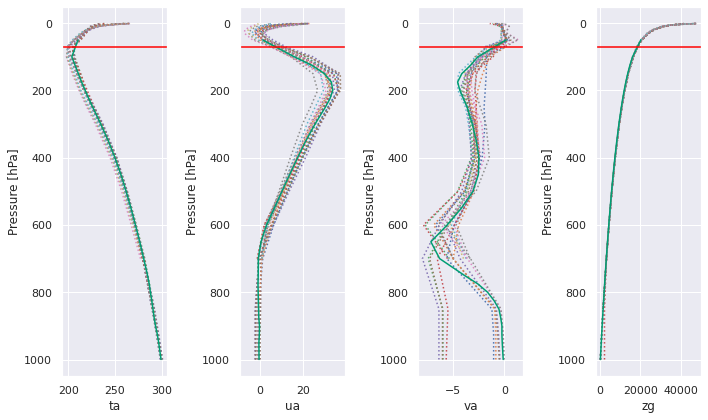

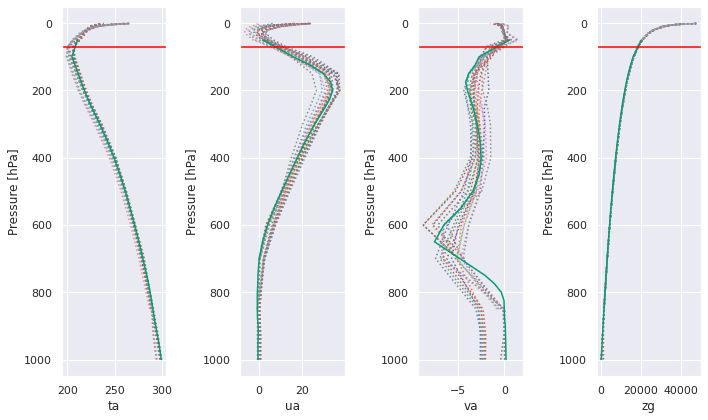

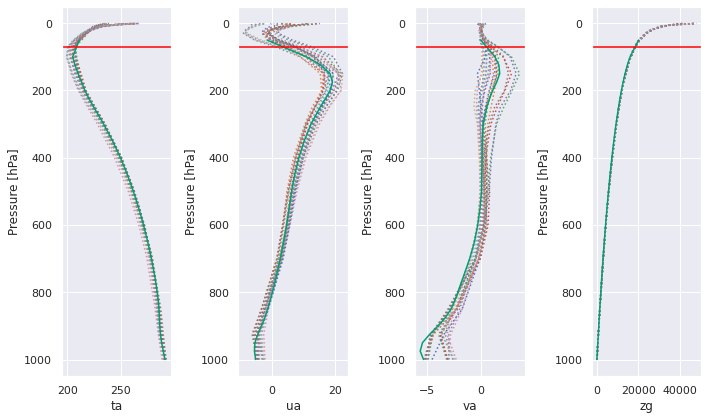

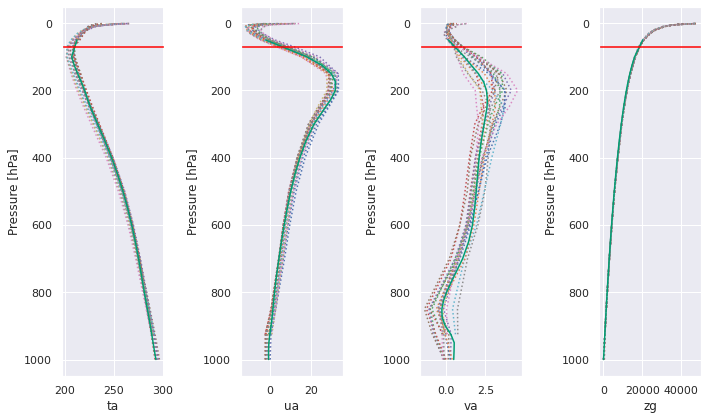

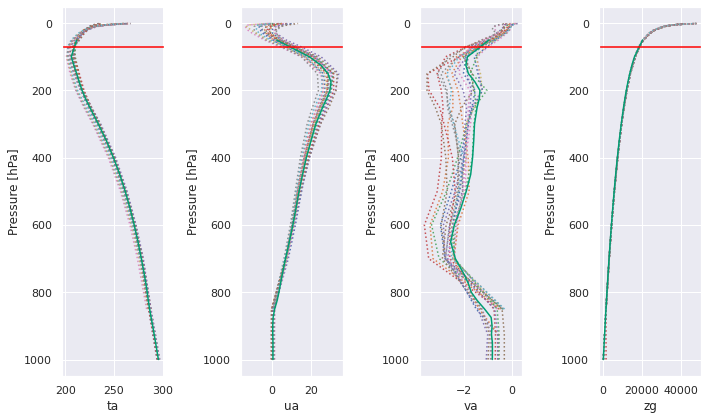

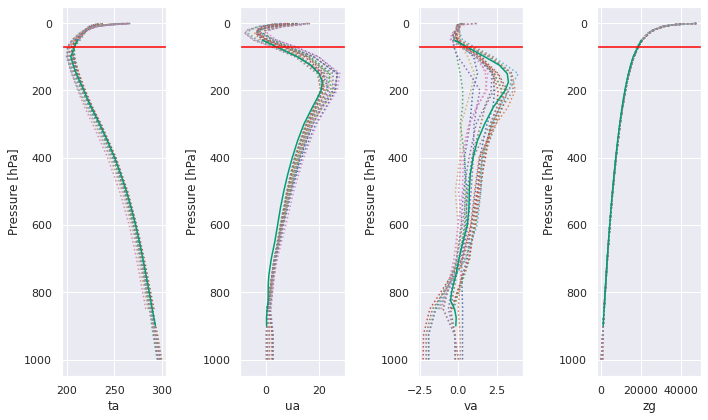

In [75]:
# loop through sites

for idx in range(0,8):

    site_name_folder = d_site_lonlat_data['site_name_folder'][idx]

    d_model = get_PRIMAVERA_seeing_vars(idx)

    fig = plot_seeing_vars_vertical_profile(idx, d_model)

    # save fig
    fig.savefig('./Model_evaluation/seeing_nc/vertical_profile_u_v_t/'+ site_name_folder + '_vertical_profile_u_v_t.png', bbox_inches = 'tight', pad_inches=0.0, dpi=400)

# remember: ua: eastward wind (going to the east (jet stream!)), va: northward wind


In [76]:
site_name_folder


'SPM'

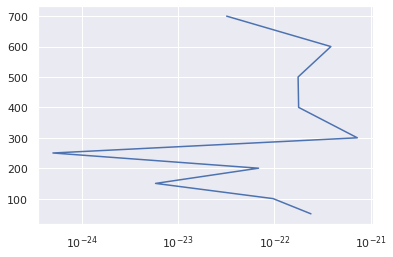

In [79]:
plt.plot(ls_cn2, ls_pr)
plt.xscale('log')

In [80]:
# up: ERA5

In [81]:
#down: PRIMAVERA

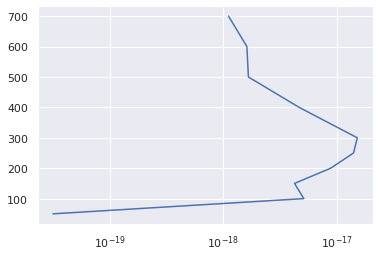

In [83]:
plt.plot(ls_cn2, ls_pr)
plt.xscale('log')

In [84]:
# plot Cn2 (possible?)
# calc cn2 out of medians


PRIMAVERA = True
ERA5 = True

# k_factor = climxa.PRIMAVERA_calc_seeing(ds_full, mean_insitu, lon, lat, T_clim_var, U_clim_var, V_clim_var, Z_clim_var, pr_levels_list, site, clim_key, forcing, PRIMAVERA_surface_pressure_value)


# PRIMAVERA
if PRIMAVERA:
    ds_full = d_model['HadGEM']['ds_seeing'].median(dim='time')
    # pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000

    forcing = 'hist'

    T_clim_var = 'ta ' + forcing
    U_clim_var = 'ua ' + forcing
    V_clim_var = 'va ' + forcing
    Z_clim_var = 'zg ' + forcing

# ERA5
if ERA5:
    ds_full = ds_ERA5_median
    ds_ERA5_median['z'] = ds_ERA5_median['z']/10

    list(ds_ERA5_median.level.values)

    T_clim_var = 't'
    U_clim_var = 'u'
    V_clim_var = 'v'
    Z_clim_var = 'z'

pr_levels_list = [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850] # , 925, 1000


J = 0

ls_pr = []
ls_cn2 = []

for i in range(0, len(pr_levels_list)-1):
    # print(pr_levels_list[i])
    T = ds_full[T_clim_var].sel(level=pr_levels_list[i])
    P = ds_full.level[i]
    u_i0 = ds_full[U_clim_var].sel(level=pr_levels_list[i])
    u_i1 = ds_full[U_clim_var].sel(level=pr_levels_list[i+1])
    v_i0 = ds_full[V_clim_var].sel(level=pr_levels_list[i]) 
    v_i1 = ds_full[V_clim_var].sel(level=pr_levels_list[i+1])
    T1 = ds_full[T_clim_var].sel(level=pr_levels_list[i+1])
    P1 = ds_full.level[int(i+1)] 
    df_z_0 = ds_full[Z_clim_var].sel(level=pr_levels_list[i]) # do not divide by g, it is already in m (model data)
    if i == 0:
        df_z_m1 = 0
    else:
        df_z_m1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i-1])
    df_z_p1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i+1])
    # integrate (sum)
    J_add = climxa.Cn2_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)

    # test if climxa.Cn2_func() doesn't return NaN
    ds_check = J_add.where(xr.ufuncs.isnan(J_add) != True, drop = True)
    # print(ds_check['time'].size)

    J = J + J_add

    # (for Cn2 profile, do not sum over Cn2, but store Cn2 on pressure level dimension)
    # do that!! (and only if J_add is not nan)
    ds_Cn2 = climxa.Cn2_profile_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)
    ls_pr.append(pr_levels_list[i])
    ls_cn2.append(ds_Cn2.values)

    # ds_Cn2 = ds_Cn2.assign_coords({"level": pr_levels_list[i]})



    # print(f'Cn2 = {ds_Cn2}')
    # print(f'pressure level = {pr_levels_list[i]}')

    # # concatenate DataArrays along new dimension 'level'
    # if i == 0:
    #     ds_Cn2_profile = ds_Cn2
    # else:
    #     ds_Cn2_profile = xr.concat([ds_Cn2_profile, ds_Cn2], 'level')

    # just use list to append



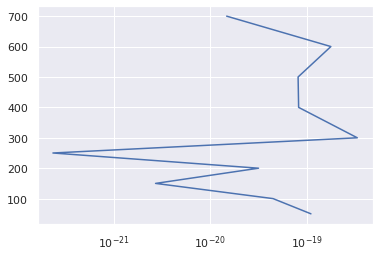

In [85]:
plt.plot(ls_cn2, ls_pr)
plt.xscale('log')

In [86]:
# plot Cn2 (possible?)
# calc cn2 out of medians


PRIMAVERA = True
ERA5 = True

# k_factor = climxa.PRIMAVERA_calc_seeing(ds_full, mean_insitu, lon, lat, T_clim_var, U_clim_var, V_clim_var, Z_clim_var, pr_levels_list, site, clim_key, forcing, PRIMAVERA_surface_pressure_value)


# PRIMAVERA
if PRIMAVERA:
    ds_full = d_model['HadGEM']['ds_seeing'].median(dim='time')
    # pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000

    forcing = 'hist'

    T_clim_var = 'ta ' + forcing
    U_clim_var = 'ua ' + forcing
    V_clim_var = 'va ' + forcing
    Z_clim_var = 'zg ' + forcing

# ERA5
if ERA5:
    ds_full = ds_ERA5_median
    ds_ERA5_median['z'] = ds_ERA5_median['z']/100

    list(ds_ERA5_median.level.values)

    T_clim_var = 't'
    U_clim_var = 'u'
    V_clim_var = 'v'
    Z_clim_var = 'z'

pr_levels_list = [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850] # , 925, 1000


J = 0

ls_pr = []
ls_cn2 = []

for i in range(0, len(pr_levels_list)-1):
    # print(pr_levels_list[i])
    T = ds_full[T_clim_var].sel(level=pr_levels_list[i])
    P = ds_full.level[i]
    u_i0 = ds_full[U_clim_var].sel(level=pr_levels_list[i])
    u_i1 = ds_full[U_clim_var].sel(level=pr_levels_list[i+1])
    v_i0 = ds_full[V_clim_var].sel(level=pr_levels_list[i]) 
    v_i1 = ds_full[V_clim_var].sel(level=pr_levels_list[i+1])
    T1 = ds_full[T_clim_var].sel(level=pr_levels_list[i+1])
    P1 = ds_full.level[int(i+1)] 
    df_z_0 = ds_full[Z_clim_var].sel(level=pr_levels_list[i]) # do not divide by g, it is already in m (model data)
    if i == 0:
        df_z_m1 = 0
    else:
        df_z_m1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i-1])
    df_z_p1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i+1])
    # integrate (sum)
    J_add = climxa.Cn2_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)

    # test if climxa.Cn2_func() doesn't return NaN
    ds_check = J_add.where(xr.ufuncs.isnan(J_add) != True, drop = True)
    # print(ds_check['time'].size)

    J = J + J_add

    # (for Cn2 profile, do not sum over Cn2, but store Cn2 on pressure level dimension)
    # do that!! (and only if J_add is not nan)
    ds_Cn2 = climxa.Cn2_profile_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)
    ls_pr.append(pr_levels_list[i])
    ls_cn2.append(ds_Cn2.values)

    # ds_Cn2 = ds_Cn2.assign_coords({"level": pr_levels_list[i]})



    # print(f'Cn2 = {ds_Cn2}')
    # print(f'pressure level = {pr_levels_list[i]}')

    # # concatenate DataArrays along new dimension 'level'
    # if i == 0:
    #     ds_Cn2_profile = ds_Cn2
    # else:
    #     ds_Cn2_profile = xr.concat([ds_Cn2_profile, ds_Cn2], 'level')

    # just use list to append



In [88]:
# plot Cn2 (possible?)
# calc cn2 out of medians


PRIMAVERA = True
ERA5 = True

# k_factor = climxa.PRIMAVERA_calc_seeing(ds_full, mean_insitu, lon, lat, T_clim_var, U_clim_var, V_clim_var, Z_clim_var, pr_levels_list, site, clim_key, forcing, PRIMAVERA_surface_pressure_value)


# PRIMAVERA
if PRIMAVERA:
    ds_full = d_model['HadGEM']['ds_seeing'].median(dim='time')
    # pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000

    forcing = 'hist'

    T_clim_var = 'ta ' + forcing
    U_clim_var = 'ua ' + forcing
    V_clim_var = 'va ' + forcing
    Z_clim_var = 'zg ' + forcing

# ERA5
if ERA5:
    ds_full = ds_ERA5_median
    ds_ERA5_median['z'] = ds_ERA5_median['z']/10

    list(ds_ERA5_median.level.values)

    T_clim_var = 't'
    U_clim_var = 'u'
    V_clim_var = 'v'
    Z_clim_var = 'z'

pr_levels_list = [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850] # , 925, 1000


J = 0

ls_pr = []
ls_cn2 = []

for i in range(0, len(pr_levels_list)-1):
    # print(pr_levels_list[i])
    T = ds_full[T_clim_var].sel(level=pr_levels_list[i])
    P = ds_full.level[i]
    u_i0 = ds_full[U_clim_var].sel(level=pr_levels_list[i])
    u_i1 = ds_full[U_clim_var].sel(level=pr_levels_list[i+1])
    v_i0 = ds_full[V_clim_var].sel(level=pr_levels_list[i]) 
    v_i1 = ds_full[V_clim_var].sel(level=pr_levels_list[i+1])
    T1 = ds_full[T_clim_var].sel(level=pr_levels_list[i+1])
    P1 = ds_full.level[int(i+1)] 
    df_z_0 = ds_full[Z_clim_var].sel(level=pr_levels_list[i]) # do not divide by g, it is already in m (model data)
    if i == 0:
        df_z_m1 = 0
    else:
        df_z_m1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i-1])
    df_z_p1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i+1])
    # integrate (sum)
    J_add = climxa.Cn2_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)

    # test if climxa.Cn2_func() doesn't return NaN
    ds_check = J_add.where(xr.ufuncs.isnan(J_add) != True, drop = True)
    # print(ds_check['time'].size)

    J = J + J_add

    # (for Cn2 profile, do not sum over Cn2, but store Cn2 on pressure level dimension)
    # do that!! (and only if J_add is not nan)
    ds_Cn2 = climxa.Cn2_profile_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)
    ls_pr.append(pr_levels_list[i])
    ls_cn2.append(ds_Cn2.values)

    # ds_Cn2 = ds_Cn2.assign_coords({"level": pr_levels_list[i]})



    # print(f'Cn2 = {ds_Cn2}')
    # print(f'pressure level = {pr_levels_list[i]}')

    # # concatenate DataArrays along new dimension 'level'
    # if i == 0:
    #     ds_Cn2_profile = ds_Cn2
    # else:
    #     ds_Cn2_profile = xr.concat([ds_Cn2_profile, ds_Cn2], 'level')

    # just use list to append



In [90]:
median_path = './Astroclimate_outcome/median_nc_u_v_t/' + site_name_folder + '_median_ERA5_u_v_t_z.nc'


In [91]:
median_path

'./Astroclimate_outcome/median_nc_u_v_t/SPM_median_ERA5_u_v_t_z.nc'

In [93]:
ds_ERA5_median = xr.open_dataset(median_path).load()


In [94]:
# plot Cn2 (possible?)
# calc cn2 out of medians


PRIMAVERA = True
ERA5 = True

# k_factor = climxa.PRIMAVERA_calc_seeing(ds_full, mean_insitu, lon, lat, T_clim_var, U_clim_var, V_clim_var, Z_clim_var, pr_levels_list, site, clim_key, forcing, PRIMAVERA_surface_pressure_value)


# PRIMAVERA
if PRIMAVERA:
    ds_full = d_model['HadGEM']['ds_seeing'].median(dim='time')
    # pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000

    forcing = 'hist'

    T_clim_var = 'ta ' + forcing
    U_clim_var = 'ua ' + forcing
    V_clim_var = 'va ' + forcing
    Z_clim_var = 'zg ' + forcing

# ERA5
if ERA5:
    ds_full = ds_ERA5_median
    ds_full['z'] = ds_full['z']/10

    list(ds_ERA5_median.level.values)

    T_clim_var = 't'
    U_clim_var = 'u'
    V_clim_var = 'v'
    Z_clim_var = 'z'

pr_levels_list = [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850] # , 925, 1000


J = 0

ls_pr = []
ls_cn2 = []

for i in range(0, len(pr_levels_list)-1):
    # print(pr_levels_list[i])
    T = ds_full[T_clim_var].sel(level=pr_levels_list[i])
    P = ds_full.level[i]
    u_i0 = ds_full[U_clim_var].sel(level=pr_levels_list[i])
    u_i1 = ds_full[U_clim_var].sel(level=pr_levels_list[i+1])
    v_i0 = ds_full[V_clim_var].sel(level=pr_levels_list[i]) 
    v_i1 = ds_full[V_clim_var].sel(level=pr_levels_list[i+1])
    T1 = ds_full[T_clim_var].sel(level=pr_levels_list[i+1])
    P1 = ds_full.level[int(i+1)] 
    df_z_0 = ds_full[Z_clim_var].sel(level=pr_levels_list[i]) # do not divide by g, it is already in m (model data)
    if i == 0:
        df_z_m1 = 0
    else:
        df_z_m1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i-1])
    df_z_p1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i+1])
    # integrate (sum)
    J_add = climxa.Cn2_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)

    # test if climxa.Cn2_func() doesn't return NaN
    ds_check = J_add.where(xr.ufuncs.isnan(J_add) != True, drop = True)
    # print(ds_check['time'].size)

    J = J + J_add

    # (for Cn2 profile, do not sum over Cn2, but store Cn2 on pressure level dimension)
    # do that!! (and only if J_add is not nan)
    ds_Cn2 = climxa.Cn2_profile_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)
    ls_pr.append(pr_levels_list[i])
    ls_cn2.append(ds_Cn2.values)

    # ds_Cn2 = ds_Cn2.assign_coords({"level": pr_levels_list[i]})



    # print(f'Cn2 = {ds_Cn2}')
    # print(f'pressure level = {pr_levels_list[i]}')

    # # concatenate DataArrays along new dimension 'level'
    # if i == 0:
    #     ds_Cn2_profile = ds_Cn2
    # else:
    #     ds_Cn2_profile = xr.concat([ds_Cn2_profile, ds_Cn2], 'level')

    # just use list to append



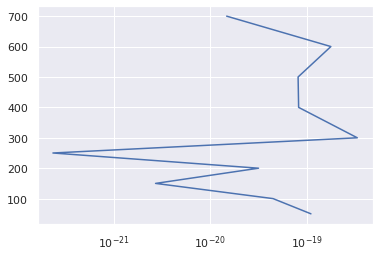

In [95]:
plt.plot(ls_cn2, ls_pr)
plt.xscale('log')

In [96]:
# plot Cn2 (possible?)
# calc cn2 out of medians


PRIMAVERA = True
ERA5 = True

# k_factor = climxa.PRIMAVERA_calc_seeing(ds_full, mean_insitu, lon, lat, T_clim_var, U_clim_var, V_clim_var, Z_clim_var, pr_levels_list, site, clim_key, forcing, PRIMAVERA_surface_pressure_value)


# PRIMAVERA
if PRIMAVERA:
    ds_full = d_model['HadGEM']['ds_seeing'].median(dim='time')
    # pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000

    forcing = 'hist'

    T_clim_var = 'ta ' + forcing
    U_clim_var = 'ua ' + forcing
    V_clim_var = 'va ' + forcing
    Z_clim_var = 'zg ' + forcing

# ERA5
if ERA5:
    ds_full = ds_ERA5_median
    ds_full['z'] = ds_full['z']/10

    list(ds_ERA5_median.level.values)

    T_clim_var = 't'
    U_clim_var = 'u'
    V_clim_var = 'v'
    Z_clim_var = 'z'

pr_levels_list = [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850] # , 925, 1000


J = 0

ls_pr = []
ls_cn2 = []

for i in range(0, len(pr_levels_list)-1):
    # print(pr_levels_list[i])
    T = ds_full[T_clim_var].sel(level=pr_levels_list[i])
    P = ds_full.level[i]
    u_i0 = ds_full[U_clim_var].sel(level=pr_levels_list[i])
    u_i1 = ds_full[U_clim_var].sel(level=pr_levels_list[i+1])
    v_i0 = ds_full[V_clim_var].sel(level=pr_levels_list[i]) 
    v_i1 = ds_full[V_clim_var].sel(level=pr_levels_list[i+1])
    T1 = ds_full[T_clim_var].sel(level=pr_levels_list[i+1])
    P1 = ds_full.level[int(i+1)] 
    df_z_0 = ds_full[Z_clim_var].sel(level=pr_levels_list[i]) # do not divide by g, it is already in m (model data)
    if i == 0:
        df_z_m1 = 0
    else:
        df_z_m1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i-1])
    df_z_p1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i+1])
    # integrate (sum)
    J_add = climxa.Cn2_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)

    # test if climxa.Cn2_func() doesn't return NaN
    ds_check = J_add.where(xr.ufuncs.isnan(J_add) != True, drop = True)
    # print(ds_check['time'].size)

    J = J + J_add

    # (for Cn2 profile, do not sum over Cn2, but store Cn2 on pressure level dimension)
    # do that!! (and only if J_add is not nan)
    ds_Cn2 = climxa.Cn2_profile_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)
    ls_pr.append(pr_levels_list[i])
    ls_cn2.append(ds_Cn2.values)

    # ds_Cn2 = ds_Cn2.assign_coords({"level": pr_levels_list[i]})



    # print(f'Cn2 = {ds_Cn2}')
    # print(f'pressure level = {pr_levels_list[i]}')

    # # concatenate DataArrays along new dimension 'level'
    # if i == 0:
    #     ds_Cn2_profile = ds_Cn2
    # else:
    #     ds_Cn2_profile = xr.concat([ds_Cn2_profile, ds_Cn2], 'level')

    # just use list to append



In [101]:
ds_full = copy.deepcopy(ds_ERA5_median)


NameError: name 'copy' is not defined

In [102]:
import copy

In [103]:
ds_full = copy.deepcopy(ds_ERA5_median)


In [104]:
median_path = './Astroclimate_outcome/median_nc_u_v_t/' + site_name_folder + '_median_ERA5_u_v_t_z.nc'
ds_ERA5_median = xr.open_dataset(median_path).load()


In [105]:
# plot Cn2 (possible?)
# calc cn2 out of medians


PRIMAVERA = True
ERA5 = True

# k_factor = climxa.PRIMAVERA_calc_seeing(ds_full, mean_insitu, lon, lat, T_clim_var, U_clim_var, V_clim_var, Z_clim_var, pr_levels_list, site, clim_key, forcing, PRIMAVERA_surface_pressure_value)


# PRIMAVERA
if PRIMAVERA:
    ds_full = d_model['HadGEM']['ds_seeing'].median(dim='time')
    # pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000

    forcing = 'hist'

    T_clim_var = 'ta ' + forcing
    U_clim_var = 'ua ' + forcing
    V_clim_var = 'va ' + forcing
    Z_clim_var = 'zg ' + forcing

# ERA5
if ERA5:
    ds_full = copy.deepcopy(ds_ERA5_median)
    ds_full['z'] = ds_full['z']/10

    list(ds_ERA5_median.level.values)

    T_clim_var = 't'
    U_clim_var = 'u'
    V_clim_var = 'v'
    Z_clim_var = 'z'

pr_levels_list = [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850] # , 925, 1000


J = 0

ls_pr = []
ls_cn2 = []

for i in range(0, len(pr_levels_list)-1):
    # print(pr_levels_list[i])
    T = ds_full[T_clim_var].sel(level=pr_levels_list[i])
    P = ds_full.level[i]
    u_i0 = ds_full[U_clim_var].sel(level=pr_levels_list[i])
    u_i1 = ds_full[U_clim_var].sel(level=pr_levels_list[i+1])
    v_i0 = ds_full[V_clim_var].sel(level=pr_levels_list[i]) 
    v_i1 = ds_full[V_clim_var].sel(level=pr_levels_list[i+1])
    T1 = ds_full[T_clim_var].sel(level=pr_levels_list[i+1])
    P1 = ds_full.level[int(i+1)] 
    df_z_0 = ds_full[Z_clim_var].sel(level=pr_levels_list[i]) # do not divide by g, it is already in m (model data)
    if i == 0:
        df_z_m1 = 0
    else:
        df_z_m1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i-1])
    df_z_p1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i+1])
    # integrate (sum)
    J_add = climxa.Cn2_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)

    # test if climxa.Cn2_func() doesn't return NaN
    ds_check = J_add.where(xr.ufuncs.isnan(J_add) != True, drop = True)
    # print(ds_check['time'].size)

    J = J + J_add

    # (for Cn2 profile, do not sum over Cn2, but store Cn2 on pressure level dimension)
    # do that!! (and only if J_add is not nan)
    ds_Cn2 = climxa.Cn2_profile_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)
    ls_pr.append(pr_levels_list[i])
    ls_cn2.append(ds_Cn2.values)

    # ds_Cn2 = ds_Cn2.assign_coords({"level": pr_levels_list[i]})



    # print(f'Cn2 = {ds_Cn2}')
    # print(f'pressure level = {pr_levels_list[i]}')

    # # concatenate DataArrays along new dimension 'level'
    # if i == 0:
    #     ds_Cn2_profile = ds_Cn2
    # else:
    #     ds_Cn2_profile = xr.concat([ds_Cn2_profile, ds_Cn2], 'level')

    # just use list to append



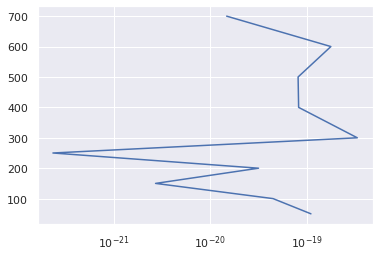

In [106]:
plt.plot(ls_cn2, ls_pr)
plt.xscale('log')

In [107]:
# plot Cn2 (possible?)
# calc cn2 out of medians


PRIMAVERA = True
ERA5 = True

# k_factor = climxa.PRIMAVERA_calc_seeing(ds_full, mean_insitu, lon, lat, T_clim_var, U_clim_var, V_clim_var, Z_clim_var, pr_levels_list, site, clim_key, forcing, PRIMAVERA_surface_pressure_value)


# PRIMAVERA
if PRIMAVERA:
    ds_full = d_model['HadGEM']['ds_seeing'].median(dim='time')
    # pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000

    forcing = 'hist'

    T_clim_var = 'ta ' + forcing
    U_clim_var = 'ua ' + forcing
    V_clim_var = 'va ' + forcing
    Z_clim_var = 'zg ' + forcing

# ERA5
if ERA5:
    ds_full = copy.deepcopy(ds_ERA5_median)
    ds_full['z'] = ds_full['z']/10

    list(ds_ERA5_median.level.values)

    T_clim_var = 't'
    U_clim_var = 'u'
    V_clim_var = 'v'
    Z_clim_var = 'z'

pr_levels_list = [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850] # , 925, 1000


J = 0

ls_pr = []
ls_cn2 = []

for i in range(0, len(pr_levels_list)-1):
    # print(pr_levels_list[i])
    T = ds_full[T_clim_var].sel(level=pr_levels_list[i])
    P = ds_full.level[i]
    u_i0 = ds_full[U_clim_var].sel(level=pr_levels_list[i])
    u_i1 = ds_full[U_clim_var].sel(level=pr_levels_list[i+1])
    v_i0 = ds_full[V_clim_var].sel(level=pr_levels_list[i]) 
    v_i1 = ds_full[V_clim_var].sel(level=pr_levels_list[i+1])
    T1 = ds_full[T_clim_var].sel(level=pr_levels_list[i+1])
    P1 = ds_full.level[int(i+1)] 
    df_z_0 = ds_full[Z_clim_var].sel(level=pr_levels_list[i]) # do not divide by g, it is already in m (model data)
    if i == 0:
        df_z_m1 = 0
    else:
        df_z_m1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i-1])
    df_z_p1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i+1])
    # integrate (sum)
    J_add = climxa.Cn2_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)

    # test if climxa.Cn2_func() doesn't return NaN
    ds_check = J_add.where(xr.ufuncs.isnan(J_add) != True, drop = True)
    # print(ds_check['time'].size)

    J = J + J_add

    # (for Cn2 profile, do not sum over Cn2, but store Cn2 on pressure level dimension)
    # do that!! (and only if J_add is not nan)
    ds_Cn2 = climxa.Cn2_profile_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)
    ls_pr.append(pr_levels_list[i])
    ls_cn2.append(ds_Cn2.values)

    # ds_Cn2 = ds_Cn2.assign_coords({"level": pr_levels_list[i]})



    # print(f'Cn2 = {ds_Cn2}')
    # print(f'pressure level = {pr_levels_list[i]}')

    # # concatenate DataArrays along new dimension 'level'
    # if i == 0:
    #     ds_Cn2_profile = ds_Cn2
    # else:
    #     ds_Cn2_profile = xr.concat([ds_Cn2_profile, ds_Cn2], 'level')

    # just use list to append



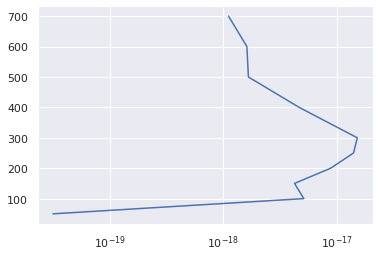

In [110]:
plt.plot(ls_cn2, ls_pr)
plt.xscale('log')

In [112]:
ds_full

<xarray.Dataset>
Dimensions:       (level: 19)
Coordinates:
  * level         (level) int64 1000 925 850 700 600 500 400 ... 50 30 20 10 5 1
Data variables:
    ua hist       (level) float64 nan nan 0.8256 3.533 ... 2.455 7.493 12.44
    ua present    (level) float64 nan nan 0.7518 3.354 ... 2.235 7.349 12.6
    ua future     (level) float64 nan nan 0.7806 3.316 ... 1.354 6.623 12.6
    ua SSTfuture  (level) float64 nan nan 0.7584 3.224 ... 1.761 7.375 11.63
    va hist       (level) float64 nan nan -0.3528 ... 0.03662 0.03467 0.3226
    va present    (level) float64 nan nan -0.4678 ... 0.02515 0.04761 0.4164
    va future     (level) float64 nan nan -0.3226 ... 0.006348 -0.01062 0.3254
    va SSTfuture  (level) float64 nan nan -0.4481 ... 0.03247 0.02759 0.3876
    zg hist       (level) float64 nan nan 1.491e+03 ... 3.581e+04 4.791e+04
    zg present    (level) float64 nan nan 1.495e+03 ... 3.581e+04 4.792e+04
    zg future     (level) float64 nan nan 1.501e+03 ... 3.572e+04 4.76e+04
    zg SSTfuture  (level) float64 nan nan 1.502e+03 ... 3.57e+04 4.763e+04
    ta hist       (level) float64 nan nan 287.1 277.7 ... 230.6 242.1 264.7
    ta present    (level) float64 nan nan 288.9 279.3 ... 230.0 241.5 264.8
    ta future     (level) float64 nan nan 289.2 279.7 ... 227.2 238.1 260.0
    ta SSTfuture  (level) float64 nan nan 291.5 281.3 ... 226.8 238.0 260.1

In [113]:
ds_full['ua hist']

<xarray.DataArray 'ua hist' (level: 19)>
array([        nan,         nan,  0.82556152,  3.53295898,  6.39990234,
        9.39196777, 13.14099121, 17.72607422, 20.75256348, 23.52905273,
       21.65368652, 12.78027344,  4.47314453, -1.0291748 , -3.6270752 ,
       -2.65466309,  2.45458984,  7.49304199, 12.44360352])
Coordinates:
  * level    (level) int64 1000 925 850 700 600 500 400 ... 70 50 30 20 10 5 1

In [115]:
list(ds_full['ua hist'].values)

[nan,
 nan,
 0.8255615234375,
 3.532958984375,
 6.39990234375,
 9.3919677734375,
 13.1409912109375,
 17.72607421875,
 20.7525634765625,
 23.529052734375,
 21.6536865234375,
 12.7802734375,
 4.47314453125,
 -1.0291748046875,
 -3.6270751953125,
 -2.6546630859375,
 2.45458984375,
 7.4930419921875,
 12.443603515625]

In [116]:
list(ds_full['ua hist'].level.values)

[1000,
 925,
 850,
 700,
 600,
 500,
 400,
 300,
 250,
 200,
 150,
 100,
 70,
 50,
 30,
 20,
 10,
 5,
 1]

In [117]:
list(ds_ERA5_median['u'].values)

[-1.253613,
 11.955747,
 16.98988,
 20.118042,
 21.344091,
 20.863682,
 19.30561,
 17.595469,
 14.419203,
 12.021363,
 10.029745,
 8.310075,
 6.8288317,
 5.570106,
 4.5230327,
 3.4563618,
 2.1462152,
 1.2208811,
 1.0100577,
 0.95928025,
 0.959328,
 0.6032784,
 0.34849018,
 0.37385225]

In [118]:
list(ds_ERA5_median.level.values)

[50,
 100,
 125,
 150,
 175,
 200,
 225,
 250,
 300,
 350,
 400,
 450,
 500,
 550,
 600,
 650,
 700,
 750,
 775,
 800,
 825,
 850,
 875,
 900]

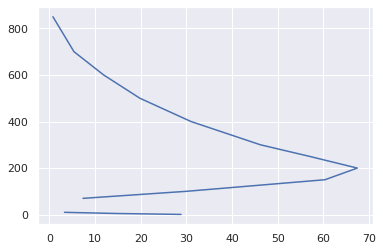

In [120]:
plt.plot(ds_full[U_clim_var]**(4/3), ds_full.level)

In [122]:
# plot Cn2 (possible?)
# calc cn2 out of medians


PRIMAVERA = True
ERA5 = True

# k_factor = climxa.PRIMAVERA_calc_seeing(ds_full, mean_insitu, lon, lat, T_clim_var, U_clim_var, V_clim_var, Z_clim_var, pr_levels_list, site, clim_key, forcing, PRIMAVERA_surface_pressure_value)


# PRIMAVERA
if PRIMAVERA:
    ds_full = d_model['HadGEM']['ds_seeing'].median(dim='time')
    # pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000

    forcing = 'hist'

    T_clim_var = 'ta ' + forcing
    U_clim_var = 'ua ' + forcing
    V_clim_var = 'va ' + forcing
    Z_clim_var = 'zg ' + forcing

# ERA5
if ERA5:
    ds_full = copy.deepcopy(ds_ERA5_median)
    ds_full['z'] = ds_full['z']/10

    list(ds_ERA5_median.level.values)

    T_clim_var = 't'
    U_clim_var = 'u'
    V_clim_var = 'v'
    Z_clim_var = 'z'

pr_levels_list = [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850] # , 925, 1000


J = 0

ls_pr = []
ls_cn2 = []

for i in range(0, len(pr_levels_list)-1):
    # print(pr_levels_list[i])
    T = ds_full[T_clim_var].sel(level=pr_levels_list[i])
    P = ds_full.level[i]
    u_i0 = ds_full[U_clim_var].sel(level=pr_levels_list[i])
    u_i1 = ds_full[U_clim_var].sel(level=pr_levels_list[i+1])
    v_i0 = ds_full[V_clim_var].sel(level=pr_levels_list[i]) 
    v_i1 = ds_full[V_clim_var].sel(level=pr_levels_list[i+1])
    T1 = ds_full[T_clim_var].sel(level=pr_levels_list[i+1])
    P1 = ds_full.level[int(i+1)] 
    df_z_0 = ds_full[Z_clim_var].sel(level=pr_levels_list[i]) # do not divide by g, it is already in m (model data)
    if i == 0:
        df_z_m1 = 0
    else:
        df_z_m1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i-1])
    df_z_p1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i+1])
    # integrate (sum)
    J_add = climxa.Cn2_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)

    # test if climxa.Cn2_func() doesn't return NaN
    ds_check = J_add.where(xr.ufuncs.isnan(J_add) != True, drop = True)
    # print(ds_check['time'].size)

    J = J + J_add

    # (for Cn2 profile, do not sum over Cn2, but store Cn2 on pressure level dimension)
    # do that!! (and only if J_add is not nan)
    ds_Cn2 = climxa.Cn2_profile_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)
    ls_pr.append(pr_levels_list[i])
    ls_cn2.append(ds_Cn2.values)

    # ds_Cn2 = ds_Cn2.assign_coords({"level": pr_levels_list[i]})



    # print(f'Cn2 = {ds_Cn2}')
    # print(f'pressure level = {pr_levels_list[i]}')

    # # concatenate DataArrays along new dimension 'level'
    # if i == 0:
    #     ds_Cn2_profile = ds_Cn2
    # else:
    #     ds_Cn2_profile = xr.concat([ds_Cn2_profile, ds_Cn2], 'level')

    # just use list to append



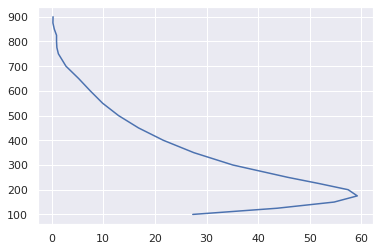

In [123]:
plt.plot(ds_full[U_clim_var]**(4/3), ds_full.level)

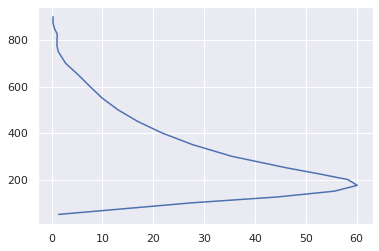

In [124]:
plt.plot(np.sqrt(ds_full[U_clim_var]**2 + ds_full[V_clim_var]**2)**(4/3), ds_full.level)

In [125]:
# plot Cn2 (possible?)
# calc cn2 out of medians


PRIMAVERA = True
ERA5 = False

# k_factor = climxa.PRIMAVERA_calc_seeing(ds_full, mean_insitu, lon, lat, T_clim_var, U_clim_var, V_clim_var, Z_clim_var, pr_levels_list, site, clim_key, forcing, PRIMAVERA_surface_pressure_value)


# PRIMAVERA
if PRIMAVERA:
    ds_full = d_model['HadGEM']['ds_seeing'].median(dim='time')
    # pr_levels_list = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000] # , 925, 1000

    forcing = 'hist'

    T_clim_var = 'ta ' + forcing
    U_clim_var = 'ua ' + forcing
    V_clim_var = 'va ' + forcing
    Z_clim_var = 'zg ' + forcing

# ERA5
if ERA5:
    ds_full = copy.deepcopy(ds_ERA5_median)
    ds_full['z'] = ds_full['z']/10

    list(ds_ERA5_median.level.values)

    T_clim_var = 't'
    U_clim_var = 'u'
    V_clim_var = 'v'
    Z_clim_var = 'z'

pr_levels_list = [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850] # , 925, 1000


J = 0

ls_pr = []
ls_cn2 = []

for i in range(0, len(pr_levels_list)-1):
    # print(pr_levels_list[i])
    T = ds_full[T_clim_var].sel(level=pr_levels_list[i])
    P = ds_full.level[i]
    u_i0 = ds_full[U_clim_var].sel(level=pr_levels_list[i])
    u_i1 = ds_full[U_clim_var].sel(level=pr_levels_list[i+1])
    v_i0 = ds_full[V_clim_var].sel(level=pr_levels_list[i]) 
    v_i1 = ds_full[V_clim_var].sel(level=pr_levels_list[i+1])
    T1 = ds_full[T_clim_var].sel(level=pr_levels_list[i+1])
    P1 = ds_full.level[int(i+1)] 
    df_z_0 = ds_full[Z_clim_var].sel(level=pr_levels_list[i]) # do not divide by g, it is already in m (model data)
    if i == 0:
        df_z_m1 = 0
    else:
        df_z_m1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i-1])
    df_z_p1 = ds_full[Z_clim_var].sel(level=pr_levels_list[i+1])
    # integrate (sum)
    J_add = climxa.Cn2_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)

    # test if climxa.Cn2_func() doesn't return NaN
    ds_check = J_add.where(xr.ufuncs.isnan(J_add) != True, drop = True)
    # print(ds_check['time'].size)

    J = J + J_add

    # (for Cn2 profile, do not sum over Cn2, but store Cn2 on pressure level dimension)
    # do that!! (and only if J_add is not nan)
    ds_Cn2 = climxa.Cn2_profile_func(T, P, u_i0, u_i1, v_i0, v_i1, T1, P1, i, df_z_0, df_z_m1, df_z_p1)
    ls_pr.append(pr_levels_list[i])
    ls_cn2.append(ds_Cn2.values)

    # ds_Cn2 = ds_Cn2.assign_coords({"level": pr_levels_list[i]})



    # print(f'Cn2 = {ds_Cn2}')
    # print(f'pressure level = {pr_levels_list[i]}')

    # # concatenate DataArrays along new dimension 'level'
    # if i == 0:
    #     ds_Cn2_profile = ds_Cn2
    # else:
    #     ds_Cn2_profile = xr.concat([ds_Cn2_profile, ds_Cn2], 'level')

    # just use list to append



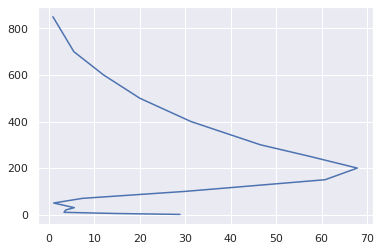

In [126]:
plt.plot(np.sqrt(ds_full[U_clim_var]**2 + ds_full[V_clim_var]**2)**(4/3), ds_full.level)

In [127]:
ds_full


<xarray.Dataset>
Dimensions:       (level: 19)
Coordinates:
  * level         (level) int64 1000 925 850 700 600 500 400 ... 50 30 20 10 5 1
Data variables:
    ua hist       (level) float64 nan nan 0.8256 3.533 ... 2.455 7.493 12.44
    ua present    (level) float64 nan nan 0.7518 3.354 ... 2.235 7.349 12.6
    ua future     (level) float64 nan nan 0.7806 3.316 ... 1.354 6.623 12.6
    ua SSTfuture  (level) float64 nan nan 0.7584 3.224 ... 1.761 7.375 11.63
    va hist       (level) float64 nan nan -0.3528 ... 0.03662 0.03467 0.3226
    va present    (level) float64 nan nan -0.4678 ... 0.02515 0.04761 0.4164
    va future     (level) float64 nan nan -0.3226 ... 0.006348 -0.01062 0.3254
    va SSTfuture  (level) float64 nan nan -0.4481 ... 0.03247 0.02759 0.3876
    zg hist       (level) float64 nan nan 1.491e+03 ... 3.581e+04 4.791e+04
    zg present    (level) float64 nan nan 1.495e+03 ... 3.581e+04 4.792e+04
    zg future     (level) float64 nan nan 1.501e+03 ... 3.572e+04 4.76e+04
    zg SSTfuture  (level) float64 nan nan 1.502e+03 ... 3.57e+04 4.763e+04
    ta hist       (level) float64 nan nan 287.1 277.7 ... 230.6 242.1 264.7
    ta present    (level) float64 nan nan 288.9 279.3 ... 230.0 241.5 264.8
    ta future     (level) float64 nan nan 289.2 279.7 ... 227.2 238.1 260.0
    ta SSTfuture  (level) float64 nan nan 291.5 281.3 ... 226.8 238.0 260.1